# Plot average dose response function
In which we try to plot the confidence interval from the ADRF, generated by bootstrapping the estimation process.

In [1]:
library(causaldrf)

## Load data

In [22]:
# load data from file
bootstrap_coeffs <- read.table('../../output/hi_est_f_success_change_param_results.tsv', sep = '\t')
bootstrap_vals <- read.table('../../output/hi_est_f_success_change_outcome_results.tsv', sep = '\t')
print(head(bootstrap_coeffs))
print(head(bootstrap_vals))

  timesteps control_vars treatment_name treatment_coeff   gps_coeff
1      1_12           DL              f       0.7155254 -1.49514738
2      1_12           DU              f       0.2846064  0.01440243
3      1_12           DS              f       0.3668490 -0.29539958
4      1_12           DT              f       0.7078381 -0.60206429
5      1_12           DL              f       0.7926517 -1.71760139
6      1_12           DU              f       0.2878414  0.44667873
  intercept_coeff iter
1       -3.956851    1
2       -4.195429    1
3       -4.136666    1
4       -4.214138    1
5       -4.007366    2
6       -4.390684    2
  timesteps treatment_name control_vars           X0       X0.01       X0.02
1      1_12             DL            f 9.769640e-06 0.003570161 0.004315507
2      1_12             DU            f 2.651183e-03 0.006443151 0.007313793
3      1_12             DS            f 6.767698e-03 0.007285071 0.007554546
4      1_12             DT            f 9.989446e-04 0.

In [28]:
# we goofed up the column names a bit womp womp
names(bootstrap_coeffs)[names(bootstrap_coeffs) == 'control_vars'] <- 'treatment_name_2'
names(bootstrap_coeffs)[names(bootstrap_coeffs) == 'treatment_name'] <- 'control_vars'
names(bootstrap_coeffs)[names(bootstrap_coeffs) == 'treatment_name_2'] <- 'treatment_name'

In [4]:
# load the raw data
combine_all_stats <- function(stats, stat_names, time_steps) {
    # compute mean for each word between timesteps
    for(s_name in stat_names){
        s <- stats[[s_name]]
        s_flat <- s[, time_steps]
        s_flat[is.na(s_flat)] <- min(s_flat)
        # compute mean over timesteps
        s_flat_df <- data.frame(apply(s_flat, 1, mean), row.names=rownames(s_flat))
        colnames(s_flat_df) <- c(s_name)
        if(length(all_stats_flat) == 0){
            all_stats_flat <- s_flat_df
        }
        else{
            all_stats_flat <- cbind(all_stats_flat, s_flat_df)
        }
    }
    # remove nan values
    all_stats_flat <- all_stats_flat[complete.cases(all_stats_flat), ]
    all_stats_vocab <- as.data.frame(rownames(all_stats_flat))
    colnames(all_stats_vocab) <- c('word')
    # Z-score standardize for ~accurate comparison~
    all_stats_flat <- as.data.frame(apply(all_stats_flat, 2, function(x) {return(scale(x))}))
    all_stats_flat <- t(data.frame(do.call(rbind, all_stats_flat)))
    # add word column
    all_stats_flat <- cbind(all_stats_flat, all_stats_vocab)
    
    return(all_stats_flat)
}

In [11]:
data_dir <- '../../data/frequency'
out_dir <- '../../output/'
tf_file <- file.path(data_dir, '2013_2016_tf_norm_log.tsv')
DL_file <- file.path(data_dir, '2013_2016_3gram_residuals.tsv')
DU_file <- file.path(data_dir, '2013_2016_user_diffusion.tsv')
DS_file <- file.path(data_dir, '2013_2016_subreddit_diffusion.tsv')
DT_file <- file.path(data_dir, '2013_2016_thread_diffusion.tsv')
f <- read.table(tf_file, sep = '\t', row.names = 1, header = TRUE, check.names = FALSE)
DL <- read.table(DL_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DU <- read.table(DU_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DS <- read.table(DS_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DT <- read.table(DT_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
# load success, failure words for later
word_dir <- file.path(data_dir, 'word_lists')
success_word_file <- file.path(word_dir, '2013_2016_growth_words_clean.csv')
fail_word_file <- file.path(word_dir, '2013_2016_growth_decline_combined.csv')
success_words <- as.character(read.csv(success_word_file, sep=',', header=TRUE)[, 'word'])
fail_words <- as.character(read.csv(fail_word_file, header=TRUE)[, 'word'])
change_words <- c(success_words, fail_words)
# get overlapping vocab
all_stats <- list(f, DL, DU, DS, DT)
all_idx <- sapply(all_stats, row.names)
vocab <- Reduce(intersect, all_idx)
# update change words to ignore stuff not in vocab
change_words <- union(change_words, vocab)
# restrict stats to vocab
f <- f[vocab,]
DL <- DL[vocab,]
DU <- DU[vocab,]
DS <- DS[vocab,]
DT <- DT[vocab,]
# combine stats
all_stats <- list(f=f, DL=DL, DS=DS, DU=DU, DT=DT)
# get time steps from coeff data
time_step_range <- as.integer(strsplit(as.character(bootstrap_coeffs[, 'timesteps'][1]), split = '_')[[1]])
time_steps <- time_step_range[1]:time_step_range[2]
stat_names <- names(all_stats)
stats_combined <- combine_all_stats(all_stats, stat_names, time_steps)

## Compute confidence intervals
We do it manually because the built-in method is dumb.

In [20]:
bootstrap_val_col_names <- colnames(bootstrap_vals)
treatment_level_names <- Filter(function(x){ return(startsWith(x, 'X'))}, bootstrap_val_col_names)
print(treatment_level_names)
treatment_levels <- as.vector(mapply(function(x){ return(as.double(gsub("X", "", x)))}, treatment_level_names))
print(treatment_levels)

  [1] "X0"    "X0.01" "X0.02" "X0.03" "X0.04" "X0.05" "X0.06" "X0.07" "X0.08"
 [10] "X0.09" "X0.1"  "X0.11" "X0.12" "X0.13" "X0.14" "X0.15" "X0.16" "X0.17"
 [19] "X0.18" "X0.19" "X0.2"  "X0.21" "X0.22" "X0.23" "X0.24" "X0.25" "X0.26"
 [28] "X0.27" "X0.28" "X0.29" "X0.3"  "X0.31" "X0.32" "X0.33" "X0.34" "X0.35"
 [37] "X0.36" "X0.37" "X0.38" "X0.39" "X0.4"  "X0.41" "X0.42" "X0.43" "X0.44"
 [46] "X0.45" "X0.46" "X0.47" "X0.48" "X0.49" "X0.5"  "X0.51" "X0.52" "X0.53"
 [55] "X0.54" "X0.55" "X0.56" "X0.57" "X0.58" "X0.59" "X0.6"  "X0.61" "X0.62"
 [64] "X0.63" "X0.64" "X0.65" "X0.66" "X0.67" "X0.68" "X0.69" "X0.7"  "X0.71"
 [73] "X0.72" "X0.73" "X0.74" "X0.75" "X0.76" "X0.77" "X0.78" "X0.79" "X0.8" 
 [82] "X0.81" "X0.82" "X0.83" "X0.84" "X0.85" "X0.86" "X0.87" "X0.88" "X0.89"
 [91] "X0.9"  "X0.91" "X0.92" "X0.93" "X0.94" "X0.95" "X0.96" "X0.97" "X0.98"
[100] "X0.99"
  [1] 0.00 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.10 0.11 0.12 0.13 0.14
 [16] 0.15 0.16 0.17 0.18 0.19 0.20 0.21 0.22 0

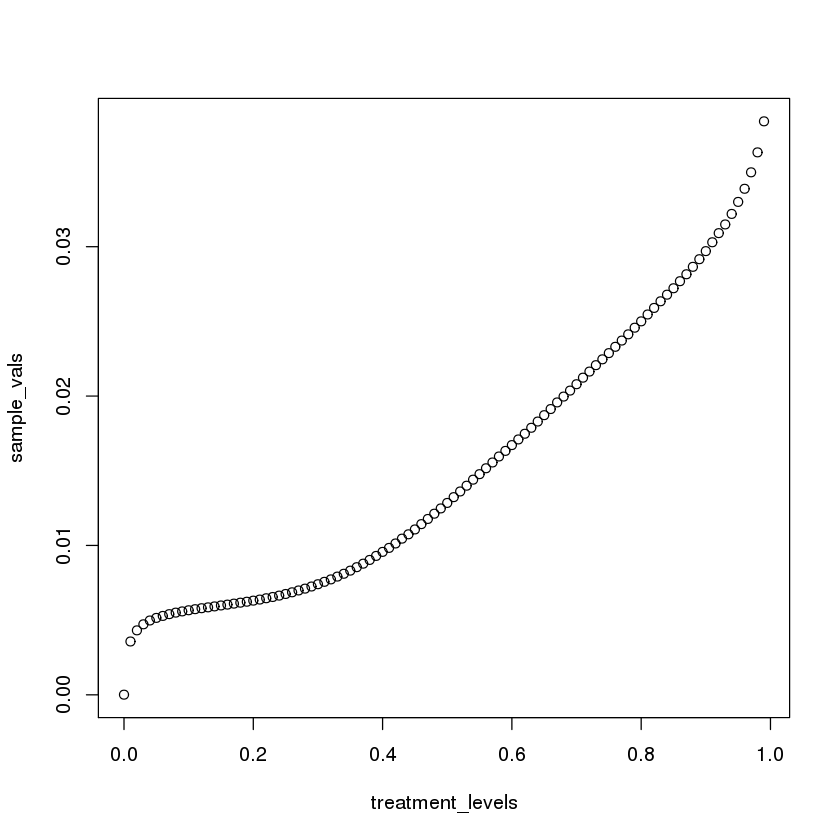

In [23]:
# plot sample dose curve
sample_idx <- 1
sample_vals <- as.vector(bootstrap_vals[sample_idx, treatment_level_names])
plot(treatment_levels, sample_vals)

Same thing but 100 times and for each treatment variable.

In [38]:
print(head(apply(vals_t[, treatment_level_names], 2, mean)))

          X0        X0.01        X0.02        X0.03        X0.04        X0.05 
0.0005396822 0.0020606494 0.0025191140 0.0028829189 0.0031753304 0.0034165074 


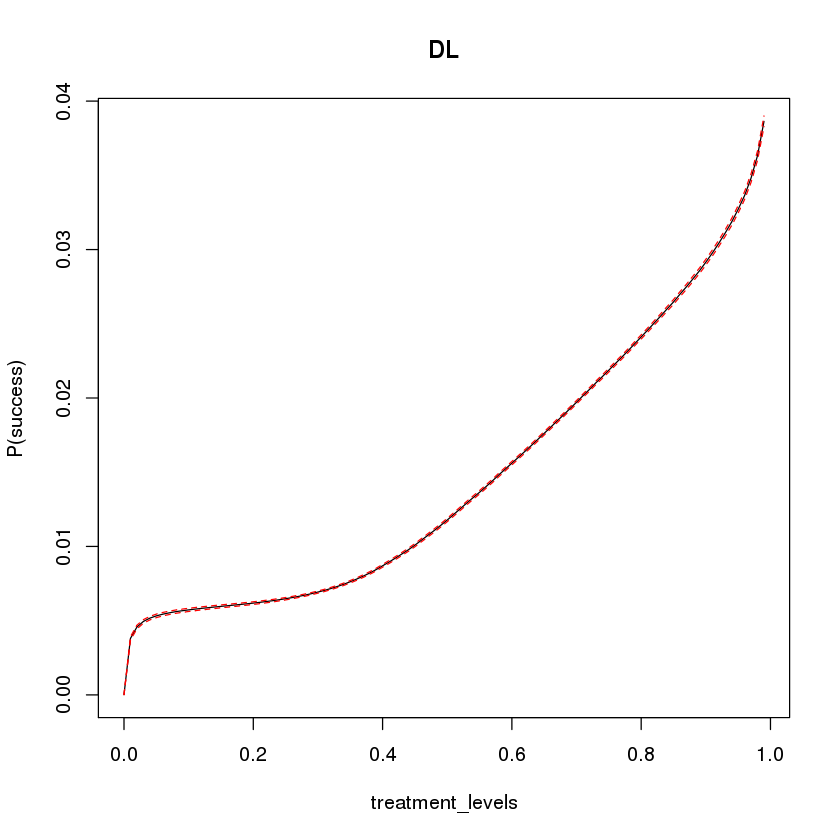

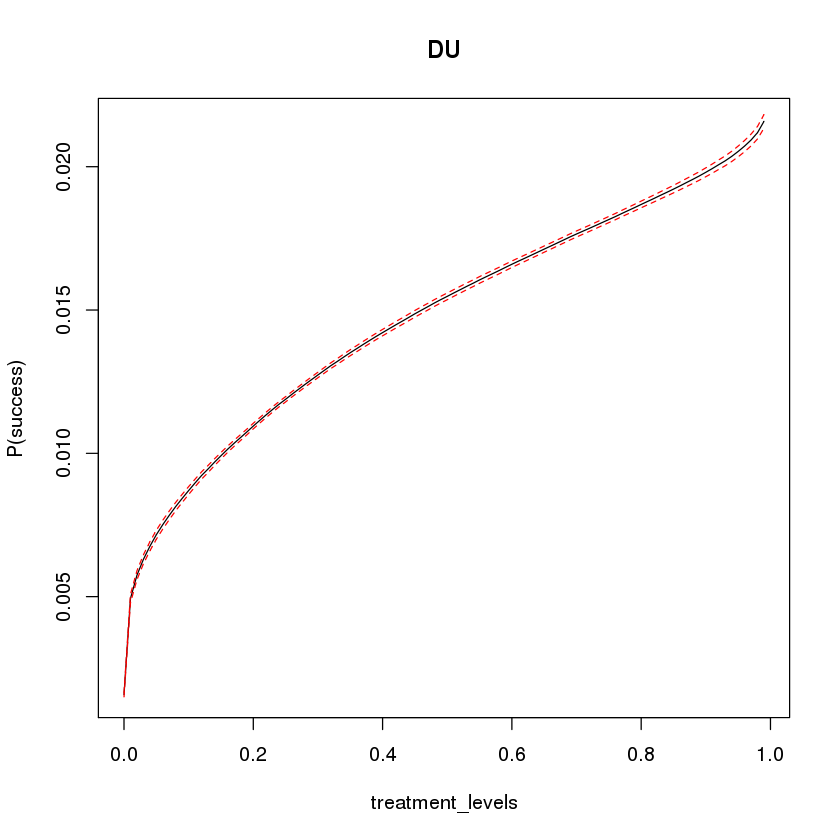

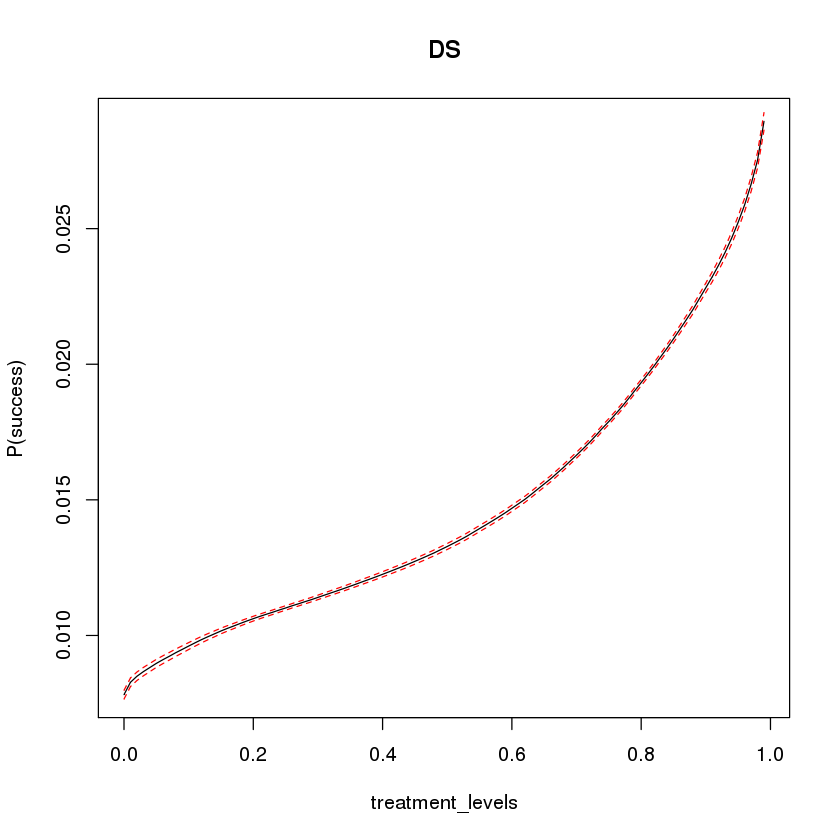

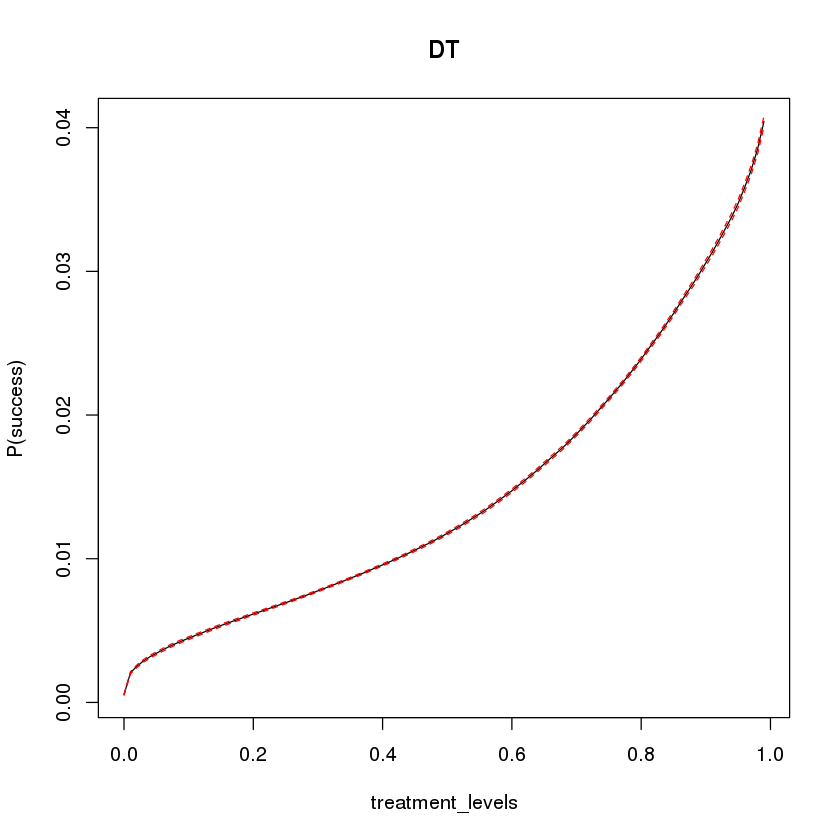

In [42]:
t_vars <- c('DL', 'DU', 'DS', 'DT')
for(t_var in t_vars){
    vals_t <- bootstrap_vals[bootstrap_vals[, 'treatment_name'] == t_var, ]
    # compute confidence intervals
    vals_t <- vals_t[, treatment_level_names]
    N <- dim(vals_t)[1]
    vals_mean <- apply(vals_t, 2, mean)
    vals_sd <- apply(vals_t, 2, sd) / N**.5
    vals_ci_upper <- vals_mean + vals_sd*1.96
    vals_ci_lower <- vals_mean - vals_sd*1.96
    # plot the mean, then the confidence intervals
    plot(treatment_levels, vals_mean, main = t_var, ylab = 'P(success)', type = 'l', col = 'black')
    lines(treatment_levels, vals_ci_lower, lty = 'dashed', col = 'red')
    lines(treatment_levels, vals_ci_upper, lty = 'dashed', col = 'red')
}

Pretty tight bounds I guess! But we need to dig deeper into why the probability of success is so low! 

I blame the regression coefficients, especially the really negative intercept value. Are we feeding the right Y data to the second regression in the HI estimator?

## Debug HI estimator
We need to break this down so we can figure out why the estimator is giving us such low probabilities.

In [1]:
source('hi_est_logit.R')

In [2]:
data_dir <- '../../data/frequency'
out_dir <- '../../output/'
tf_file <- file.path(data_dir, '2013_2016_tf_norm_log.tsv')
DL_file <- file.path(data_dir, '2013_2016_3gram_residuals.tsv')
DU_file <- file.path(data_dir, '2013_2016_user_diffusion.tsv')
DS_file <- file.path(data_dir, '2013_2016_subreddit_diffusion.tsv')
DT_file <- file.path(data_dir, '2013_2016_thread_diffusion.tsv')
f <- read.table(tf_file, sep = '\t', row.names = 1, header = TRUE, check.names = FALSE)
DL <- read.table(DL_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DU <- read.table(DU_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DS <- read.table(DS_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DT <- read.table(DT_file, sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
# load success, failure words for later
word_dir <- file.path(data_dir, 'word_lists')
success_word_file <- file.path(word_dir, '2013_2016_growth_words_clean.csv')
fail_word_file <- file.path(word_dir, '2013_2016_growth_decline_combined.csv')
success_words <- as.character(read.csv(success_word_file, sep=',', header=TRUE)[, 'word'])
fail_words <- as.character(read.csv(fail_word_file, header=TRUE)[, 'word'])
change_words <- c(success_words, fail_words)
# get overlapping vocab
all_stats <- list(f, DL, DU, DS, DT)
all_idx <- sapply(all_stats,   row.names)
vocab <- Reduce(intersect, all_idx)
# update change words to ignore stuff not in vocab
change_words <- intersect(change_words, vocab)
# restrict stats to vocab
f <- f[vocab,]
DL <- DL[vocab,]
DU <- DU[vocab,]
DS <- DS[vocab,]
DT <- DT[vocab,]

In [3]:
# load the raw data
combine_all_stats <- function(stats, stat_names, time_steps) {
    # compute mean for each word between timesteps
    all_stats_flat <- data.frame()
    for(s_name in stat_names){
        s <- stats[[s_name]]
        s_flat <- s[, time_steps]
        s_flat[is.na(s_flat)] <- min(s_flat)
        # compute mean over timesteps
        s_flat_df <- data.frame(apply(s_flat, 1, mean), row.names=rownames(s_flat))
        colnames(s_flat_df) <- c(s_name)
        if(length(all_stats_flat) == 0){
            all_stats_flat <- s_flat_df
        }
        else{
            all_stats_flat <- cbind(all_stats_flat, s_flat_df)
        }
    }
    # remove nan values
    all_stats_flat <- all_stats_flat[complete.cases(all_stats_flat), ]
    all_stats_vocab <- as.data.frame(rownames(all_stats_flat))
    colnames(all_stats_vocab) <- c('word')
    # Z-score standardize for ~accurate comparison~
    all_stats_flat <- as.data.frame(apply(all_stats_flat, 2, function(x) {return(scale(x))}))
    all_stats_flat <- t(data.frame(do.call(rbind, all_stats_flat)))
    # add word column
    all_stats_flat <- cbind(all_stats_flat, all_stats_vocab)
    
    return(all_stats_flat)
}

In [4]:
all_stats <- list(f=f, DL=DL, DS=DS, DU=DU, DT=DT)
stat_names <- names(all_stats)
# combine
time_steps <- 1:12
stats_combined <- combine_all_stats(all_stats, stat_names, time_steps)
# add success condition
stats_combined_change <- stats_combined[mapply(function(x) { return(x %in% change_words)}, stats_combined[, 'word']), ]
success_vals <- mapply(function(x) { return(as.integer(x %in% success_words))}, stats_combined_change[, 'word'])
success_vals <- data.frame(success_vals)
colnames(success_vals) <- 'success'
stats_combined_change <- cbind(stats_combined_change, success_vals)

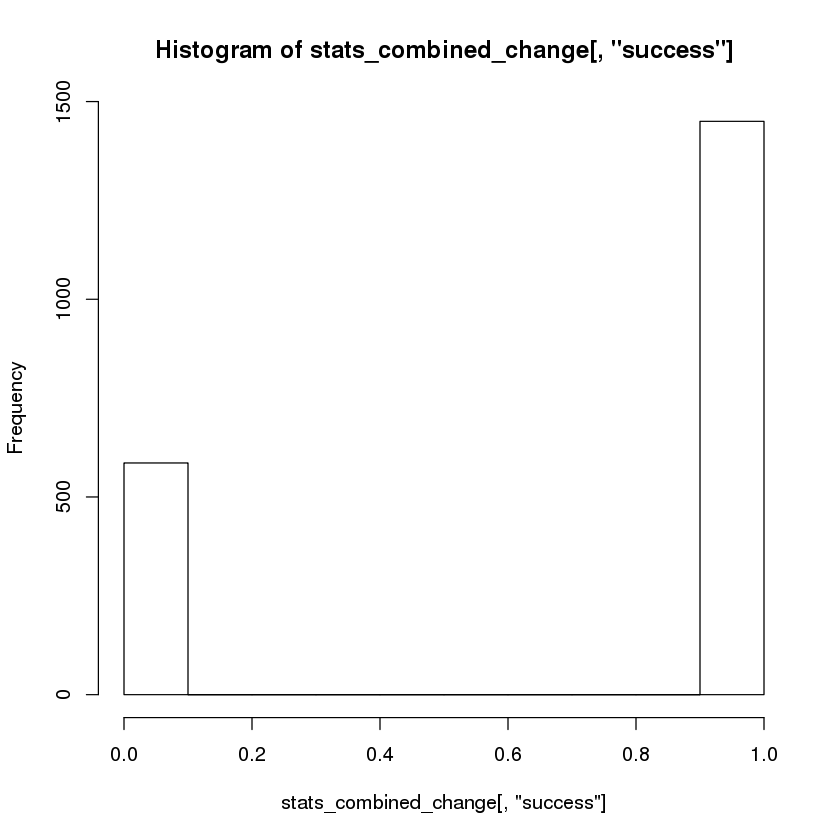

In [14]:
hist(stats_combined_change[, 'success'])

This seems reasonable! Can we try to run the estimation again and see if the results are more reasonable?

In [5]:
## estimating ADRF for given treatment (combo), control and outcome (combo) variables
run_h_estimate <- function(t_vars, c_var, o_vars, timestep_range, stats){
    ## Run the Hirano-Imbens estimator for average dose
    ## response, using the specified treatment, control and output.
    
    # if no control vars, we assume that every variable except
    # treatment is control
    c_vars_0 <- c_vars
    if(length(c_vars) > 0){
        c_var_str <- paste(c_vars, collapse=',')
    }
    all_vars <- Filter(function(x) { return(x != 'word')}, colnames(stats))
    quant_probs <- seq(0, 0.99, by=0.01)
    # parameters
    param_df <- data.frame()
    param_colnames <- c('timesteps', 'control_vars', 'treatment_name', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
    # raw generated values
    vals_df <- data.frame()
    val_colnames <- c('timesteps', 'treatment_name', 'control_vars', quant_probs)
    
    for(o_var in o_vars){
        for(t_var in t_vars){
            if(length(c_vars_0) == 0){
                c_vars <- Filter(function(x) { return(x != t_var & !(x %in% o_vars))}, all_vars)
                c_var_str <- paste(c_vars, collapse=',')
            }
            tmp_data <- as.data.frame(cbind(stats[, t_var], stats[, c_vars], stats[, o_var]))
            colnames(tmp_data) <- c('T', c_vars, 'Y')
            tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
            grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
            # generate formulae
            treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
            outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
            # convert estimator command to text and parse
            hi_est_str <- paste(c("hi_est_logit(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
            hi_estimate <- eval(parse(text=hi_est_str))
            hi_coeffs <- hi_estimate[['out_mod']][['coefficients']]
            hi_est_vals <- hi_estimate[['param']]
            param_row <- c(timestep_range, t_var, c_var_str, hi_coeffs[['T']], hi_coeffs[['gps']], hi_coeffs[['(Intercept)']])
            param_row <- t(data.frame(param_row))
            val_row <- c(timestep_range, t_var, c_var_str, hi_est_vals)
            val_row <- t(data.frame(val_row))
            if(length(param_df) == 0){
                param_df <- param_row
                vals_df <- val_row
            }
            else{
                param_df <- as.data.frame(rbind(param_df, param_row))
                vals_df <- as.data.frame(rbind(vals_df, val_row))
            }
        }
    }
    # set colnames, rownames
    colnames(param_df) <- param_colnames
    rownames(param_df) <- 1:(dim(param_df)[1])
    colnames(vals_df) <- val_colnames
    rownames(vals_df) <- 1:(dim(vals_df)[1])
    # coerce quant prob values to double
    # nope this crashes things
#     for(quant_prob in quant_probs){
#         vals_df <- eval(parse(text = paste('transform(vals_df, X', quant_prob, '=as.double("X', quant_prob, '"))', sep='')))
#     }
    results <- list(params=param_df, vals=vals_df)
    return(results)
}
## same thing but bootstrap it lol
run_bootstrap <- function(t_vars, c_vars, o_vars, timestep_range, data, bootstrap_iters){
    combined_params <- data.frame()
    combined_vals <- data.frame()
    N <- dim(data)[1]
    for(i in 1:bootstrap_iters){
        tmp_data <- data[sample(N, N, replace=TRUE), ]
        results <- run_h_estimate(t_vars, c_vars, o_vars, timestep_range, tmp_data)
        params <- results[['params']]
        vals <- results[['vals']]
        # add bootstrap iter as column
        params[, 'iter'] <- i
        vals[, 'iter'] <- i
        if(dim(combined_params)[1] == 0){
            combined_params <- params
            combined_vals <- vals
        }
        else{
            combined_params <- rbind(combined_params, params)
            combined_vals <- rbind(combined_vals, vals)
        }
        if(i %% 10 == 0){
            print(paste('processed ', i, ' bootstrap iters', sep=''))
        }
    }
    # coerce outcome probabilities to double
    treatment_level_names <- Filter(function(x){return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                    colnames(combined_vals))
    combined_vals[, treatment_level_names] <- apply(combined_vals[, treatment_level_names], 2, as.double)
    # combine finally
    combined_data <- list(params=combined_params, vals=combined_vals)
    return(combined_data)
}

In [82]:
t_vars <- c('DL', 'DU', 'DS', 'DT')
o_vars <- c('success')
word_list_name <- 'change'
c_vars <- c('f')
bootstrap_iters <- 100
timestep_range <- paste(time_steps[1], tail(time_steps,1), sep='_')
f_control_success_prob_results <- run_bootstrap(t_vars, c_vars, o_vars, timestep_range, stats_combined_change, bootstrap_iters)

[1] "processed 10 bootstrap iters"
[1] "processed 20 bootstrap iters"
[1] "processed 30 bootstrap iters"
[1] "processed 40 bootstrap iters"
[1] "processed 50 bootstrap iters"
[1] "processed 60 bootstrap iters"
[1] "processed 70 bootstrap iters"
[1] "processed 80 bootstrap iters"
[1] "processed 90 bootstrap iters"
[1] "processed 100 bootstrap iters"


In [10]:
# plot curve!!
plot_treatment_curve <- function(bootstrap_vals, t_var, treatment_level_names){
    vals_t <- bootstrap_vals[bootstrap_vals[, 'treatment_name'] == t_var, ]
    # compute confidence intervals
    vals_t <- vals_t[, treatment_level_names]
    N <- dim(vals_t)[1]
    vals_mean <- apply(vals_t, 2, mean)
    vals_sd <- apply(vals_t, 2, sd) / N**.5
    vals_ci_upper <- vals_mean + vals_sd*1.96
    vals_ci_lower <- vals_mean - vals_sd*1.96
    # plot the mean, then the confidence intervals
    treatment_levels <- as.vector(mapply(function(x){ return(as.double(gsub("X", "", x)))}, treatment_level_names))
    plot(treatment_levels, vals_mean, main = t_var, ylab = 'P(success)', type = 'l', col = 'black', xlab = 'Treatment quantile')
    lines(treatment_levels, vals_ci_lower, lty = 'dashed', col = 'red')
    lines(treatment_levels, vals_ci_upper, lty = 'dashed', col = 'red')
}

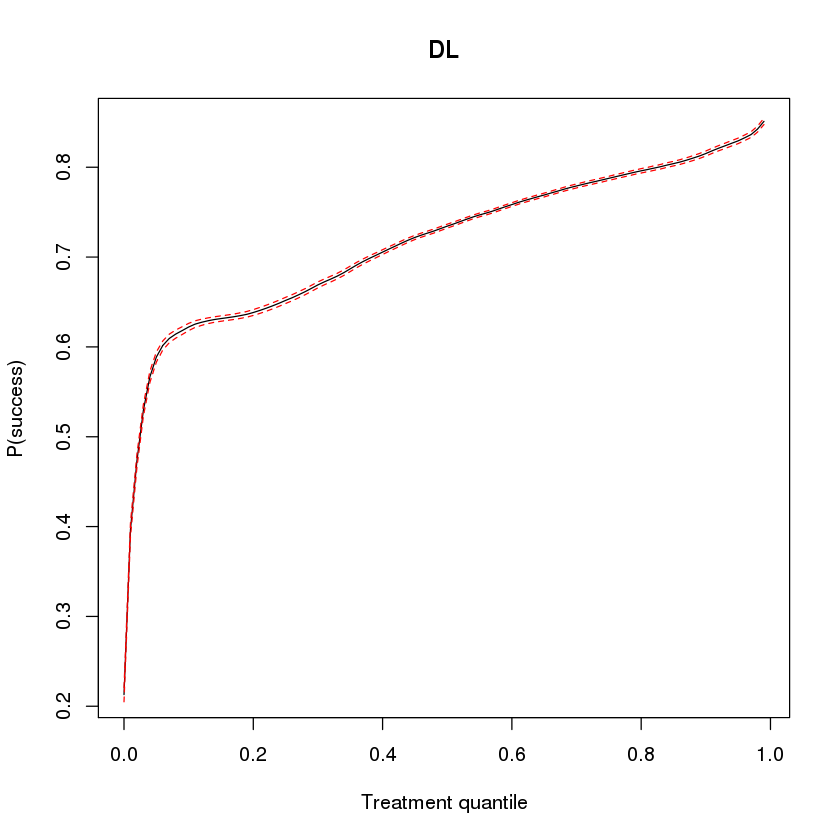

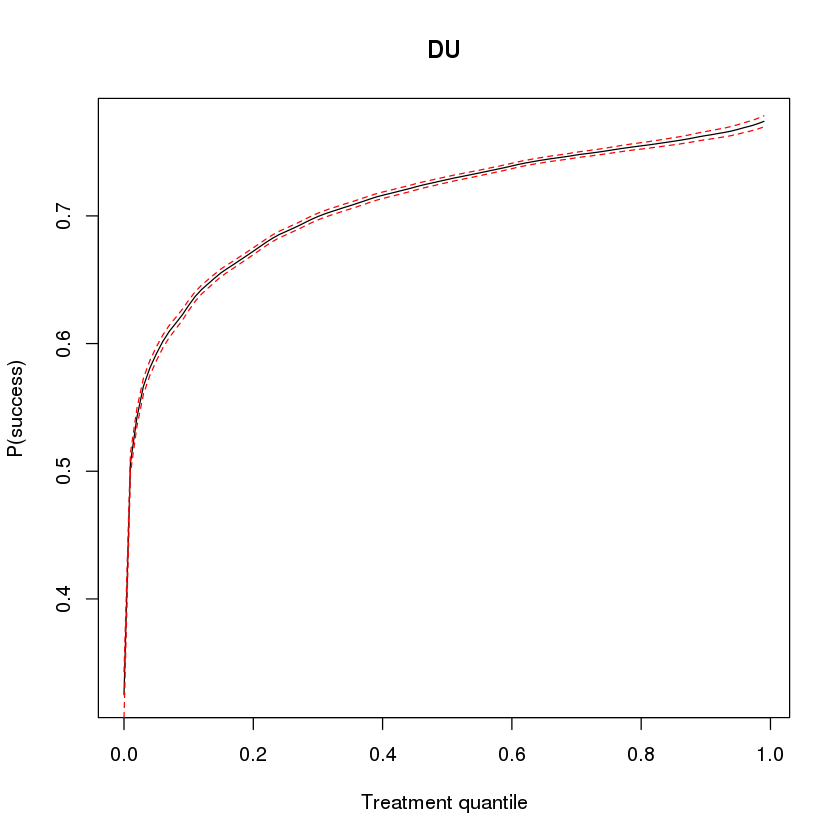

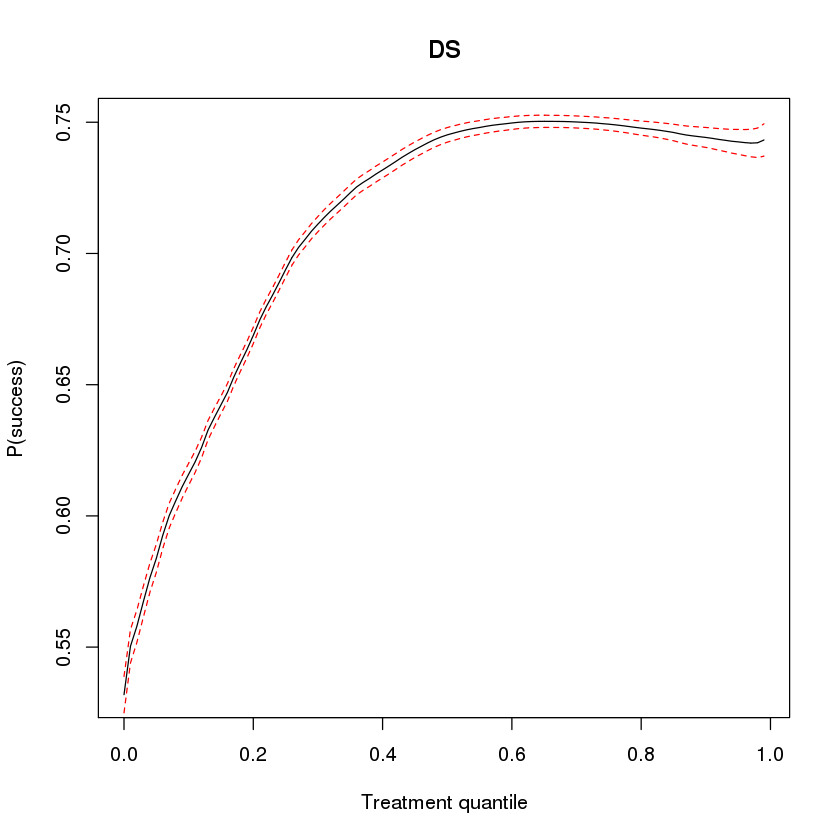

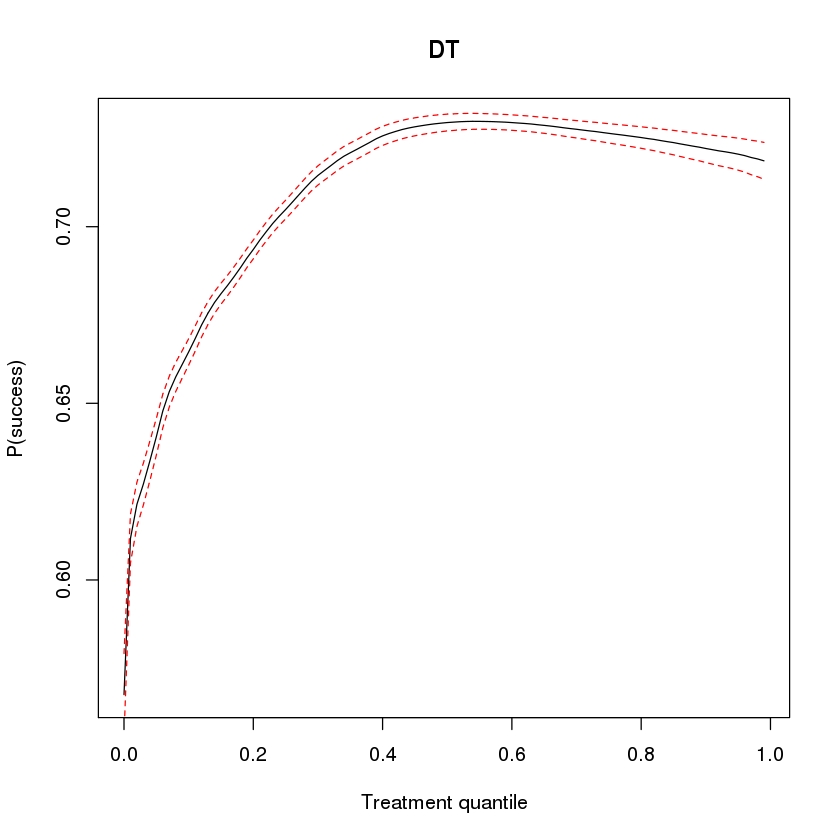

In [84]:
bootstrap_vals <- f_control_success_prob_results[['vals']]
bootstrap_val_col_names <- colnames(bootstrap_vals)
treatment_level_names <- Filter(function(x){ return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                bootstrap_val_col_names)
for(t_var in t_vars){
    plot_treatment_curve(bootstrap_vals, t_var, treatment_level_names)
}

Cool! All the curves show a positive correlation between treatment and outcome.

- DL has most dramatic increase (past 80%)
- DS and DT show slight parabola, suggesting nonlinear trends

Robustness check: let's use all control variables.

In [87]:
t_vars <- c('DL', 'DU', 'DS', 'DT')
o_vars <- c('success')
word_list_name <- 'change'
c_vars <- c()
bootstrap_iters <- 100
timestep_range <- paste(time_steps[1], tail(time_steps,1), sep='_')
all_control_success_prob_results <- run_bootstrap(t_vars, c_vars, o_vars, timestep_range, stats_combined_change, bootstrap_iters)

[1] "processed 10 bootstrap iters"
[1] "processed 20 bootstrap iters"
[1] "processed 30 bootstrap iters"
[1] "processed 40 bootstrap iters"
[1] "processed 50 bootstrap iters"
[1] "processed 60 bootstrap iters"
[1] "processed 70 bootstrap iters"
[1] "processed 80 bootstrap iters"
[1] "processed 90 bootstrap iters"
[1] "processed 100 bootstrap iters"


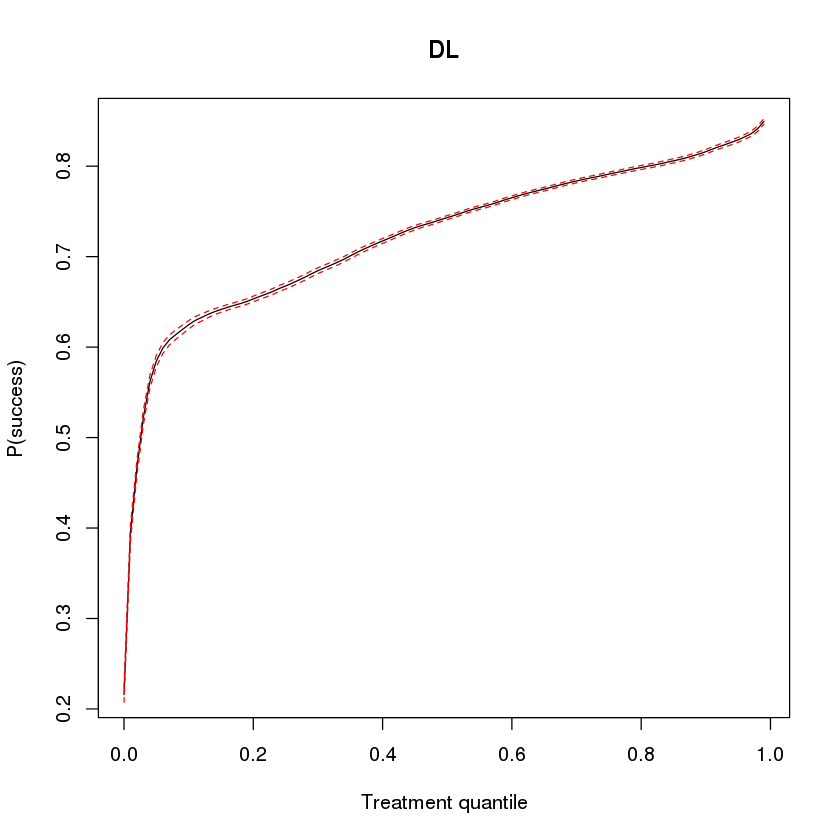

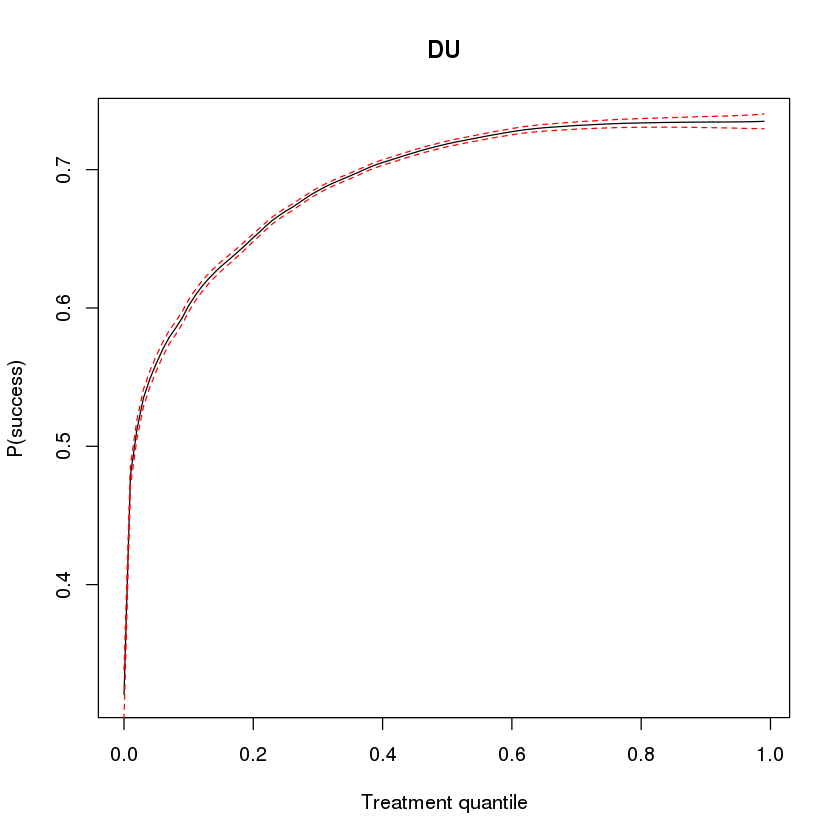

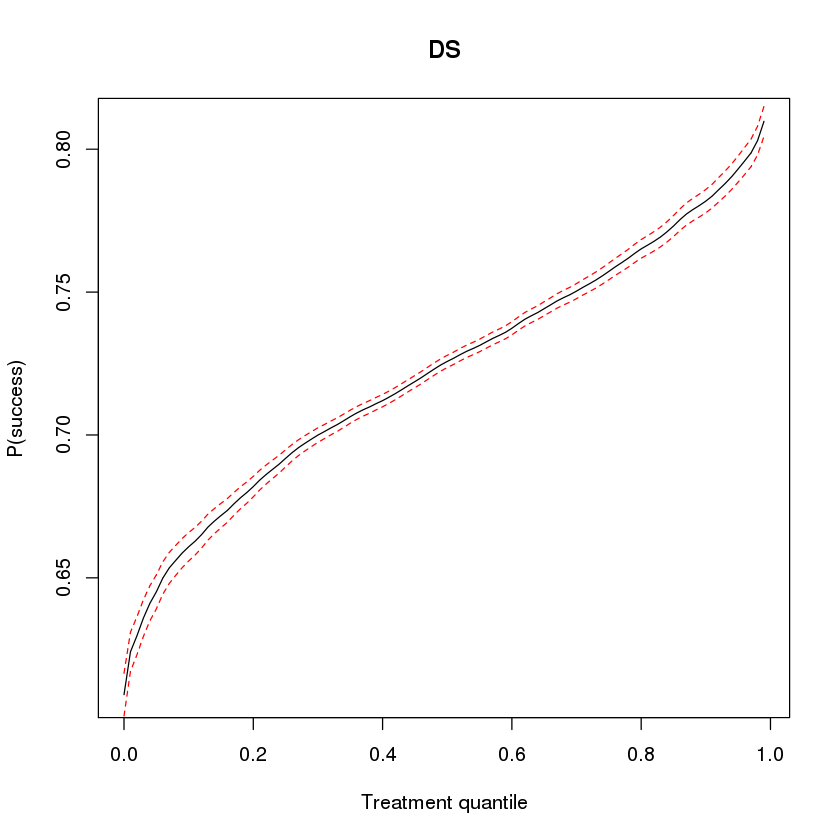

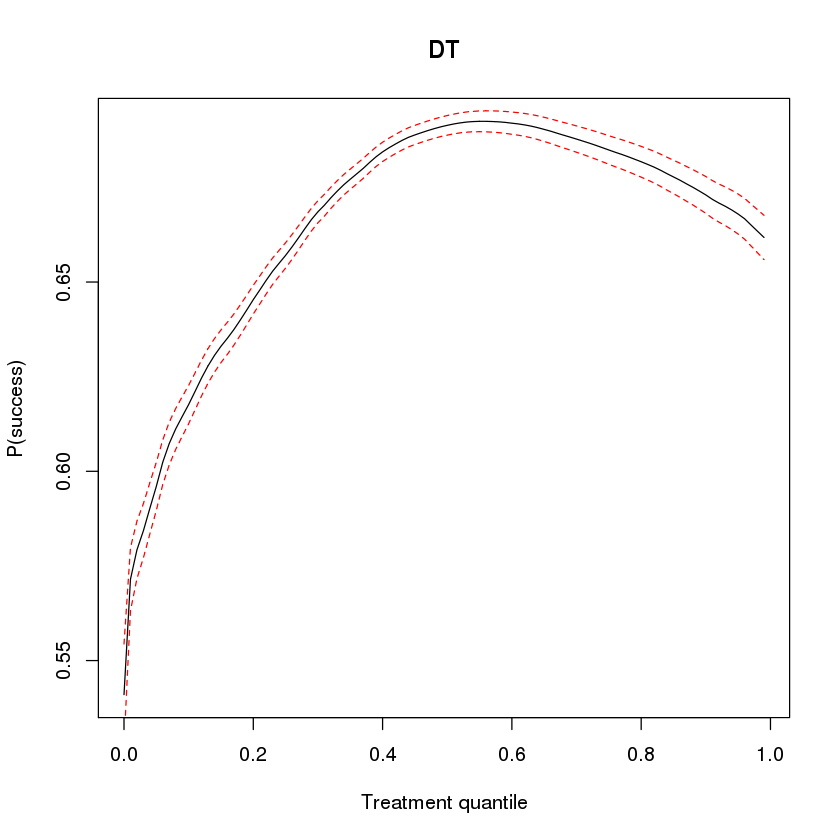

In [88]:
bootstrap_vals <- all_control_success_prob_results[['vals']]
bootstrap_val_col_names <- colnames(bootstrap_vals)
treatment_level_names <- Filter(function(x){ return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                bootstrap_val_col_names)
for(t_var in t_vars){
    plot_treatment_curve(bootstrap_vals, t_var, treatment_level_names)
}

Slightly different trends now!

- DS has sharper growth at higher treatment quantile

## Balanced classes

Same thing but when we're bootstrap sampling can we make sure that classes are balanced? Same sample size for success and fail words.

In [6]:
run_bootstrap_balanced_class <- function(t_vars, c_vars, o_vars, class_var, timestep_range, data, bootstrap_iters){
    combined_params <- data.frame()
    combined_vals <- data.frame()
    N <- dim(data)[1]
    N_minority <- as.vector(sort(table(data[, class_var]), decreasing = FALSE)[1])[1]
    class_list <- unique(data[, class_var])
    for(i in 1:bootstrap_iters){
        tmp_data <- data[sample(N, N, replace=FALSE), ]
        tmp_data_resampled <- data.frame()
        # sample same number of rows per class
        for(c in class_list){
            tmp_data_c <- data[data[, class_var] == c,]
            N_c <- dim(tmp_data_c)[1]
            tmp_data_c <- tmp_data_c[sample(N_c, N_minority, replace=TRUE), ]
            if(dim(tmp_data_resampled)[1] == 0){
                tmp_data_resampled <- tmp_data_c
            }
            else{
                tmp_data_resampled <- rbind(tmp_data_resampled, tmp_data_c)
            }
        }
        tmp_data <- tmp_data_resampled
        results <- run_h_estimate(t_vars, c_vars, o_vars, timestep_range, tmp_data)
        params <- results[['params']]
        vals <- results[['vals']]
        # add bootstrap iter as column
        params[, 'iter'] <- i
        vals[, 'iter'] <- i
        if(dim(combined_params)[1] == 0){
            combined_params <- params
            combined_vals <- vals
        }
        else{
            combined_params <- rbind(combined_params, params)
            combined_vals <- rbind(combined_vals, vals)
        }
        if(i %% 10 == 0){
            print(paste('processed ', i, ' bootstrap iters', sep=''))
        }
    }
    # coerce outcome probabilities to double
    treatment_level_names <- Filter(function(x){return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                    colnames(combined_vals))
    combined_vals[, treatment_level_names] <- apply(combined_vals[, treatment_level_names], 2, as.double)
    # combine finally
    combined_data <- list(params=combined_params, vals=combined_vals)
    return(combined_data)
}

In [122]:
t_vars <- c('DL', 'DU', 'DS', 'DT')
o_vars <- c('success')
c_vars <- c()
class_var <- 'success'
bootstrap_iters <- 100
timestep_range <- paste(time_steps[1], tail(time_steps,1), sep='_')
all_control_success_prob_results <- run_bootstrap_balanced_class(t_vars, c_vars, o_vars, class_var, timestep_range, stats_combined_change, bootstrap_iters)

[1] "processed 10 bootstrap iters"
[1] "processed 20 bootstrap iters"
[1] "processed 30 bootstrap iters"
[1] "processed 40 bootstrap iters"
[1] "processed 50 bootstrap iters"
[1] "processed 60 bootstrap iters"
[1] "processed 70 bootstrap iters"
[1] "processed 80 bootstrap iters"
[1] "processed 90 bootstrap iters"
[1] "processed 100 bootstrap iters"


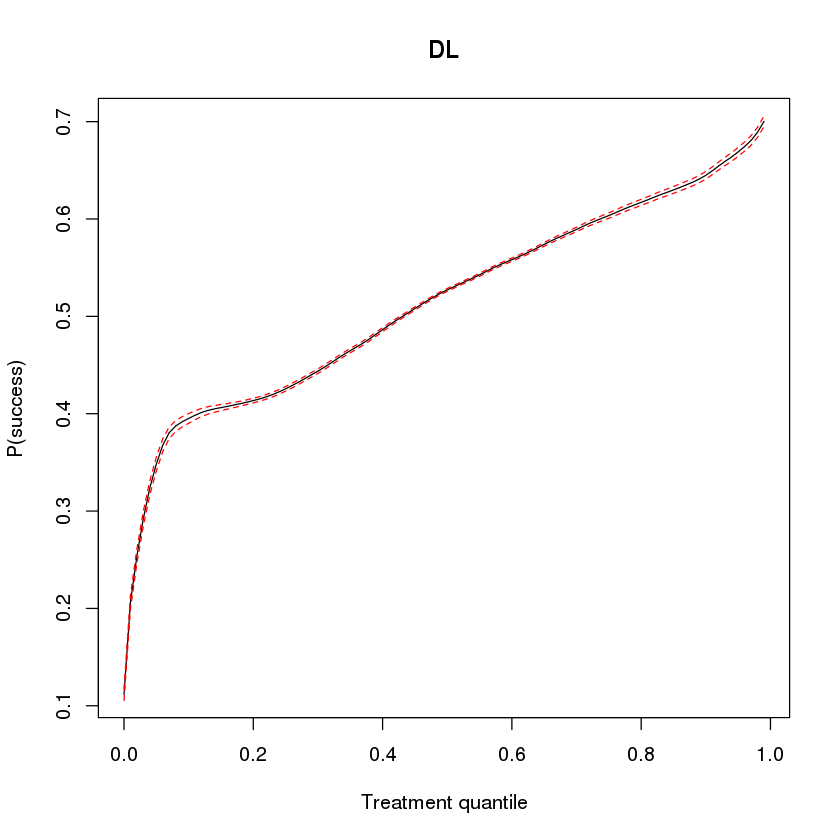

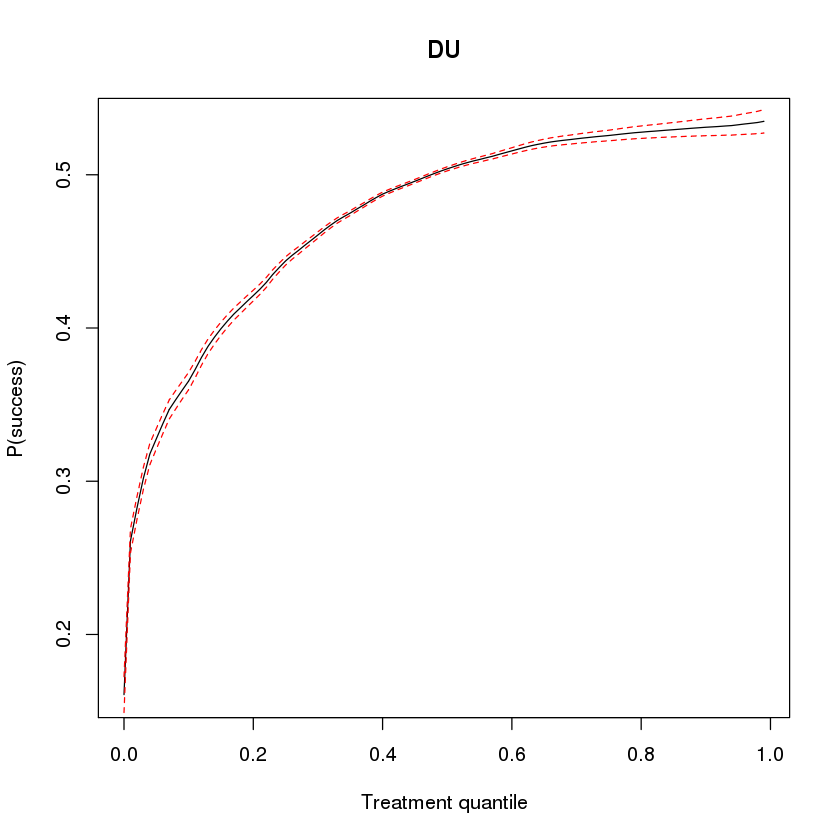

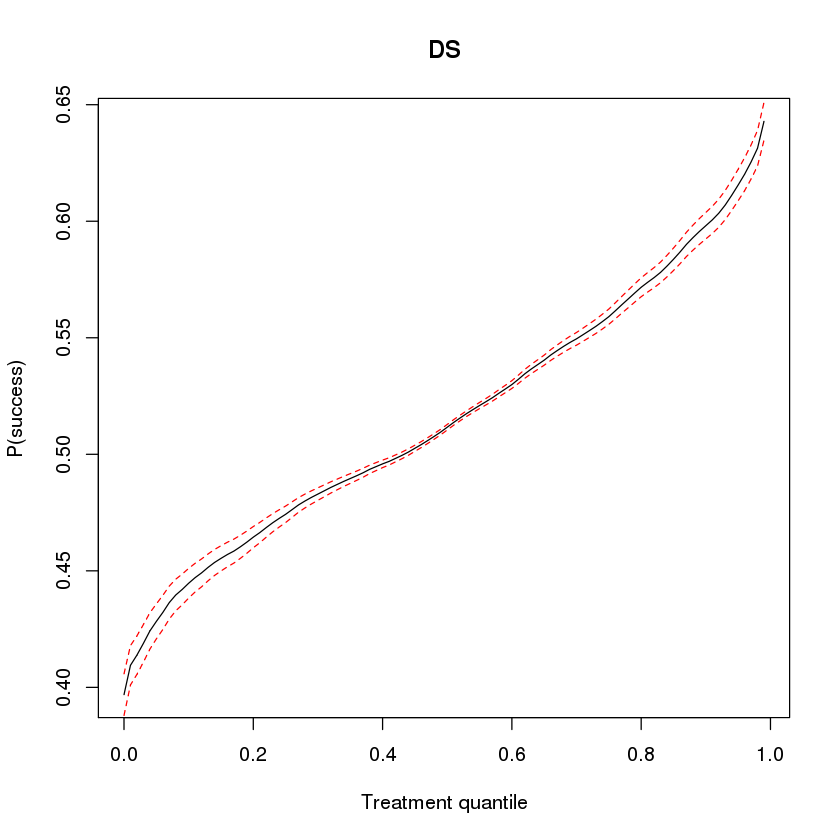

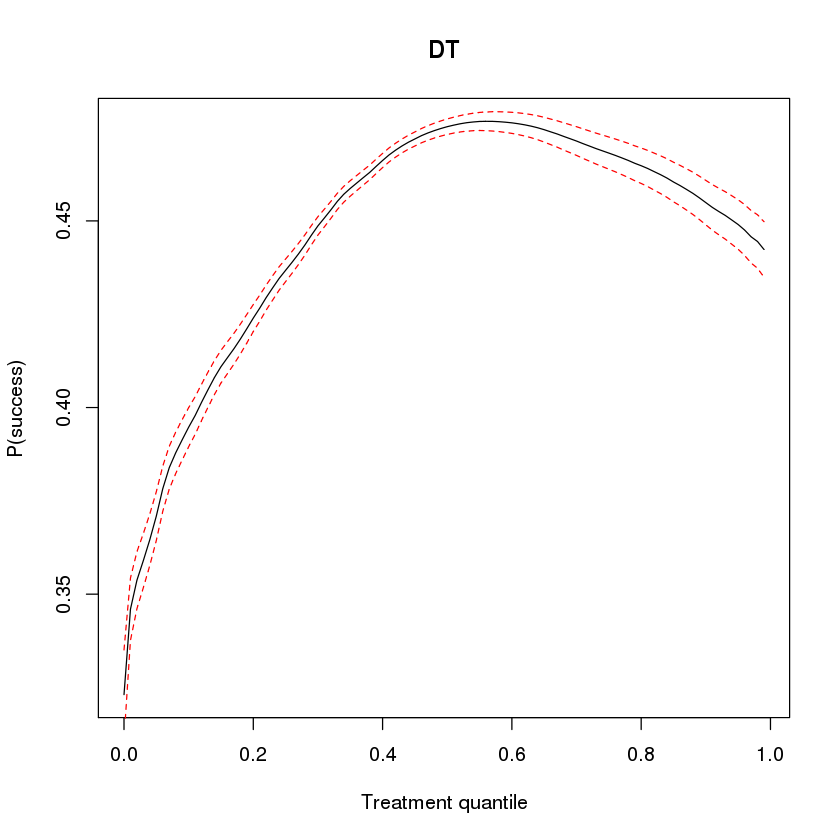

In [11]:
bootstrap_vals <- all_control_success_prob_results[['vals']]
bootstrap_val_col_names <- colnames(bootstrap_vals)
treatment_level_names <- Filter(function(x){ return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                bootstrap_val_col_names)
for(t_var in t_vars){
    plot_treatment_curve(bootstrap_vals, t_var, treatment_level_names)
}

There we go, that looks more reasonable. Now we don't have the imbalance problem and it looks like $DL$ is behaving more reasonably, hitting 50% success at 50% treatment. Maybe a linear solution is the right one after all!!

In [98]:
plot_treatment_curve <- function(bootstrap_vals, t_var, treatment_level_names, x_lim=c(0,1.), y_lim=c(0,1.)){
    vals_t <- bootstrap_vals[bootstrap_vals[, 'treatment_name'] == t_var, ]
    # compute confidence intervals
    vals_t <- vals_t[, treatment_level_names]
    N <- dim(vals_t)[1]
    vals_mean <- apply(vals_t, 2, mean)
    vals_sd <- apply(vals_t, 2, sd) / N**.5
    vals_ci_upper <- vals_mean + vals_sd*1.96
    vals_ci_lower <- vals_mean - vals_sd*1.96
    # plot the mean, then the confidence intervals
    treatment_levels <- as.vector(mapply(function(x){ return(as.double(gsub("X", "", x)))}, treatment_level_names))
    # optional xlim and ylim
    if(length(x_lim) != 2){
        x_lim <- c(min(treatment_levels), max(treatment_levels))
    }
    if(length(y_lim) != 2){
        y_lim <- c(min(vals_ci_lower), max(vals_ci_upper))
    }
    plot(treatment_levels, vals_mean, main = t_var, type = 'l', col = 'black', 
         xlab = 'Treatment quantile', ylab = 'P(success)', 
         xlim=x_lim, ylim=y_lim, xaxs='i', yaxs='i')
    lines(treatment_levels, vals_ci_lower, lty = 'dashed', col = 'red')
    lines(treatment_levels, vals_ci_upper, lty = 'dashed', col = 'red')
}

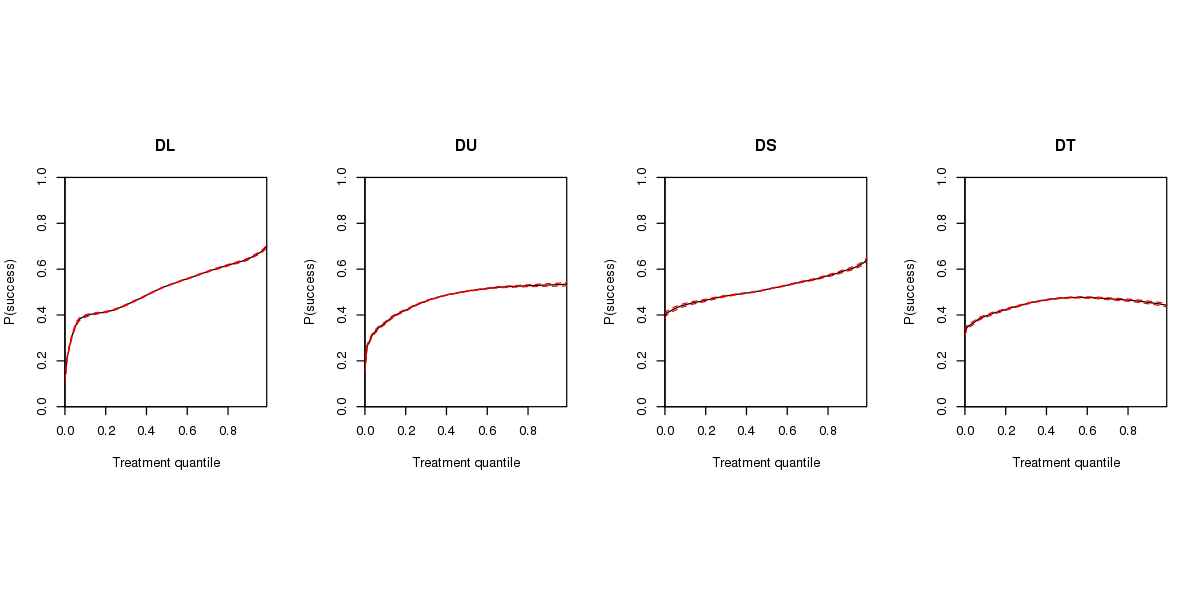

In [100]:
# same plots but sharing y-axis
library(ggplot2)
library(repr)
options(repr.plot.width=10, repr.plot.height=5)
rows <- 1
cols <- length(t_vars)
# cols <- 2
o_var <- 'success'
treatment_levels <- as.double(treatment_level_names)
x_lim <- c(min(treatment_levels), max(treatment_levels))
y_lim <- c(0., 1.)
height <- 1.25
width <- 1.
# graph_list <- list()
l <- layout(matrix(c(1,2,3,4), ncol = cols), width, height, respect = TRUE)
for(t_var in t_vars){
    plot_treatment_curve(bootstrap_vals, t_var, treatment_level_names, 
                         x_lim=x_lim, y_lim=y_lim)
# #     plot_str <- paste('ggplot(bootstrap_vals, aes(x=', t_var, ', y=', o_var, '))', 
# #                           ' + geom_point() + xlim(', x_lim[1], ',', x_lim[2], ')',
# #                           '+ ylim(', y_lim[1], ',', y_lim[2], ')', sep='')
#     g <- eval(parse(text = plot_str))
#     graph_list[[t_var]] <- g
}

Robustness: same thing but with frequency alone.

In [103]:
t_vars <- c('DL', 'DU', 'DS', 'DT')
o_vars <- c('success')
c_vars <- c('f')
class_var <- 'success'
bootstrap_iters <- 100
timestep_range <- paste(time_steps[1], tail(time_steps,1), sep='_')
f_control_success_prob_results <- run_bootstrap_balanced_class(t_vars, c_vars, o_vars, class_var, timestep_range, stats_combined_change, bootstrap_iters)

[1] "processed 10 bootstrap iters"
[1] "processed 20 bootstrap iters"
[1] "processed 30 bootstrap iters"
[1] "processed 40 bootstrap iters"
[1] "processed 50 bootstrap iters"
[1] "processed 60 bootstrap iters"
[1] "processed 70 bootstrap iters"
[1] "processed 80 bootstrap iters"
[1] "processed 90 bootstrap iters"
[1] "processed 100 bootstrap iters"


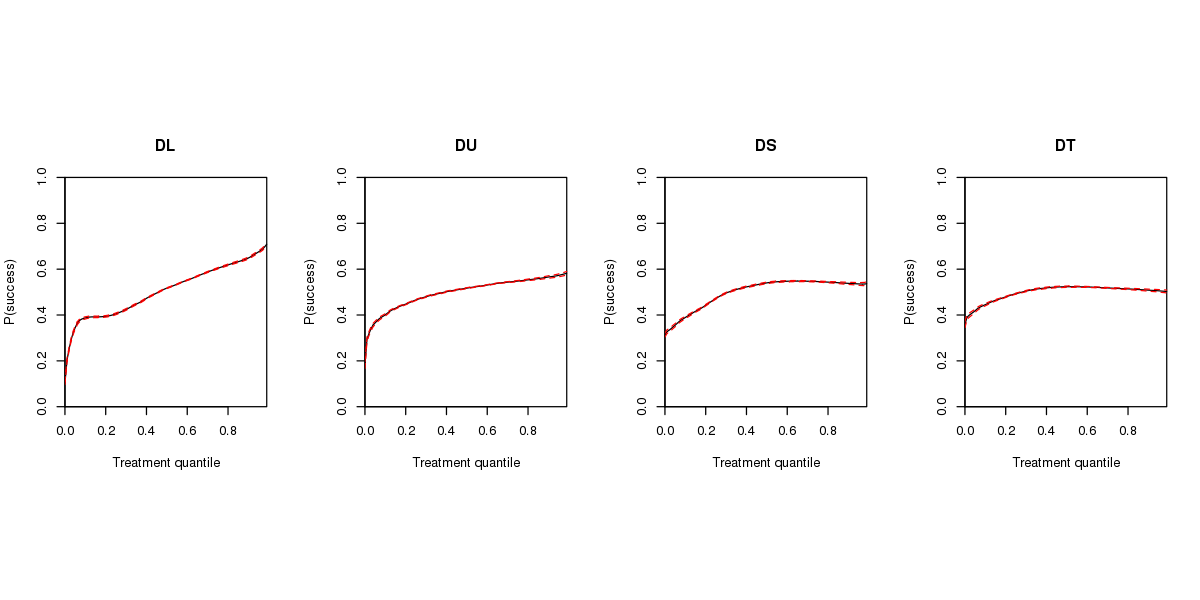

In [104]:
bootstrap_vals <- f_control_success_prob_results[['vals']]
bootstrap_val_col_names <- colnames(bootstrap_vals)
treatment_level_names <- Filter(function(x){ return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                bootstrap_val_col_names)
rows <- 1
cols <- length(t_vars)
# cols <- 2
o_var <- 'success'
treatment_levels <- as.double(treatment_level_names)
x_lim <- c(min(treatment_levels), max(treatment_levels))
y_lim <- c(0., 1.)
height <- 1.25
width <- 1.
# graph_list <- list()
l <- layout(matrix(c(1,2,3,4), ncol = cols), width, height, respect = TRUE)
for(t_var in t_vars){
    plot_treatment_curve(bootstrap_vals, t_var, treatment_level_names, 
                         x_lim=x_lim, y_lim=y_lim)
}

Wow! These patterns are pretty much identical to the all-control condition. So let's just use the all-control condition as our default.

## Plot other timestep range results
We've run other timestep ranges as robustness checks, so let's plot them out to make sure they make sense.

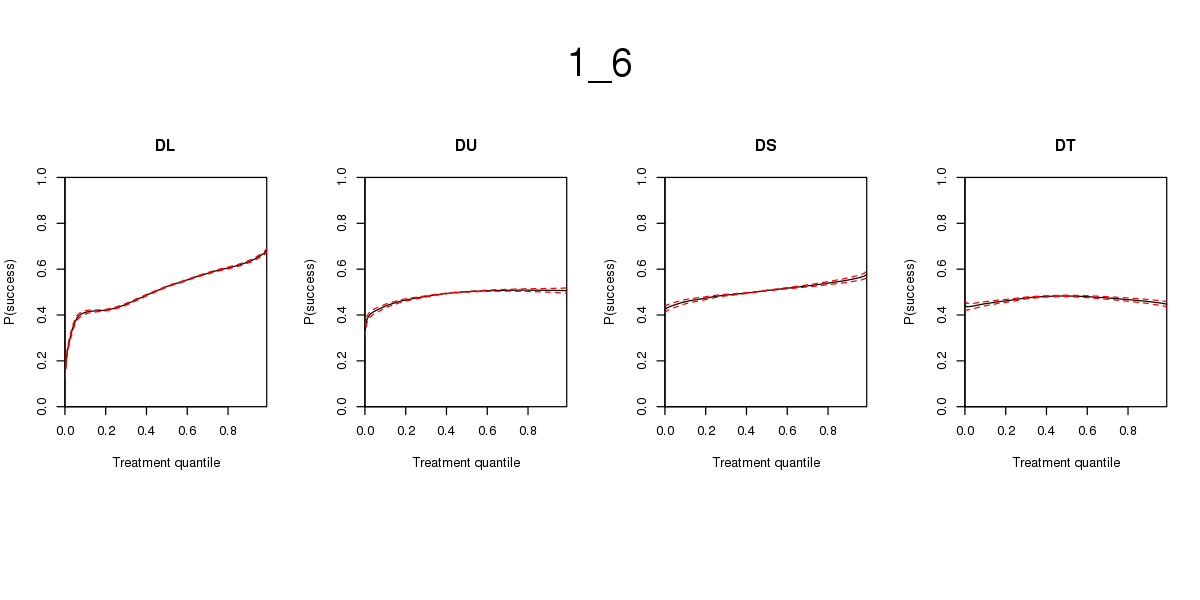

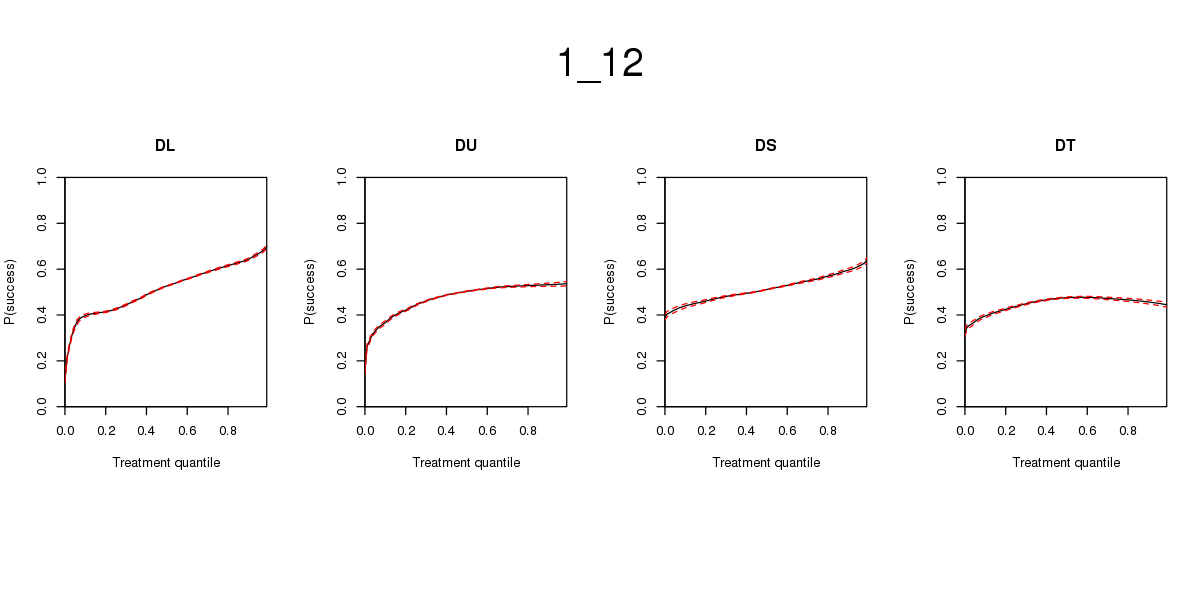

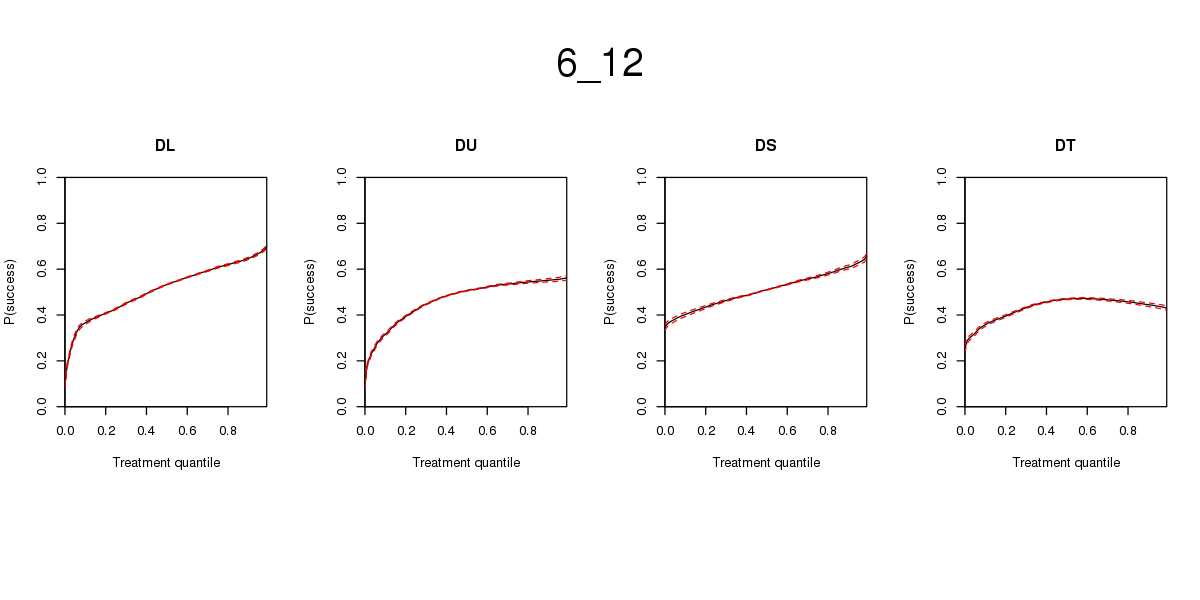

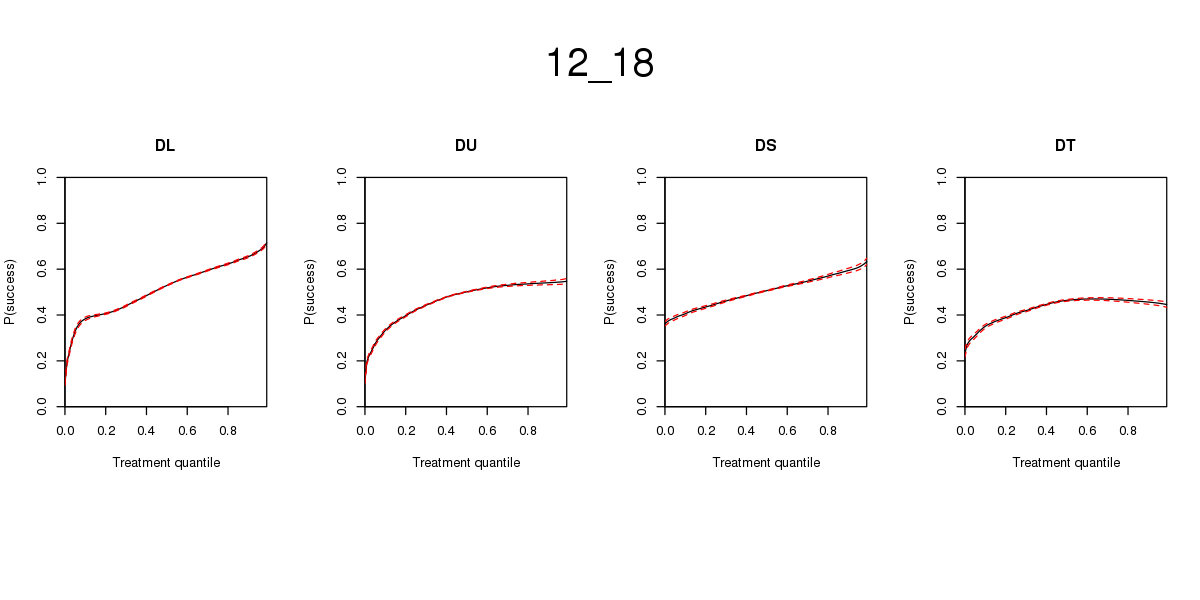

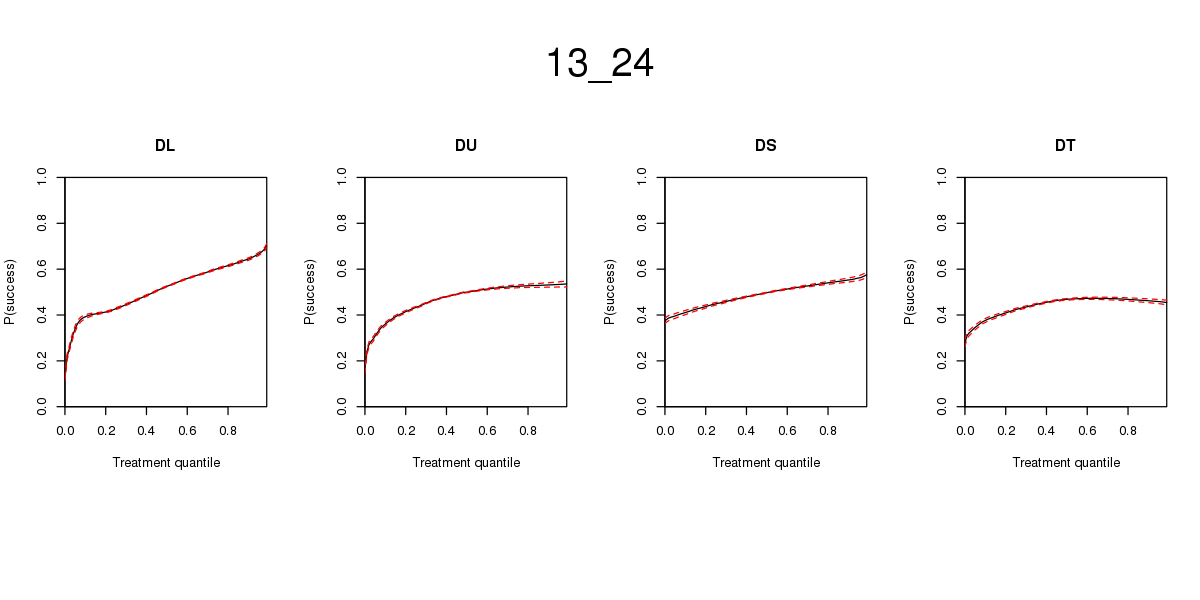

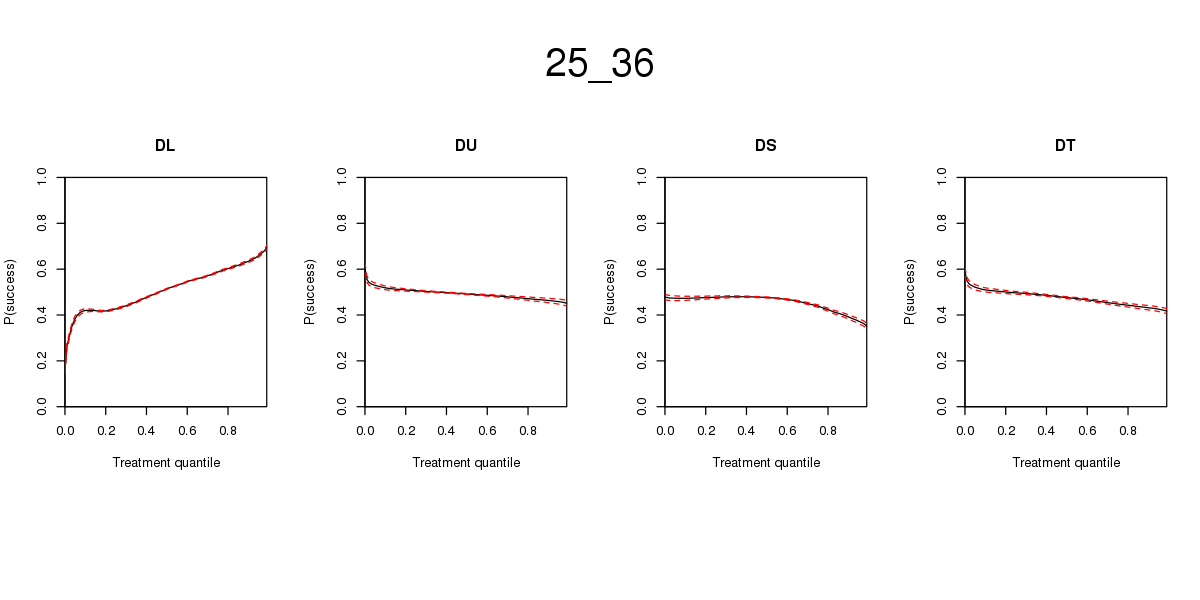

In [180]:
plot_bootstrap_vals <- function(bootstrap_vals, timestep_range){
    t_vars <- unique(bootstrap_vals[, 'treatment_name'])
    bootstrap_val_col_names <- colnames(bootstrap_vals)
    treatment_level_names <- Filter(function(x){ return(x != 'timesteps' & x != 'treatment_name' & x != 'control_vars' & x != 'iter')}, 
                                    bootstrap_val_col_names)
    rows <- 1
    cols <- length(t_vars)
    o_var <- 'success'
    treatment_levels <- as.double(treatment_level_names)
    x_lim <- c(min(treatment_levels), max(treatment_levels))
    y_lim <- c(0., 1.)
    height <- 1.25
    width <- 1.
    title_y_offset <- -5
    title_size <- 2.
    l <- layout(matrix(c(1,2,3,4), ncol = cols), width, height, respect = TRUE)
    for(t_var in t_vars){
        plot_treatment_curve(bootstrap_vals, t_var, treatment_level_names, 
                             x_lim=x_lim, y_lim=y_lim)
    }
    mtext(timestep_range, side = 3, line = title_y_offset, outer = TRUE, cex = title_size)
}
out_dir <- '../../output/'
dir_pattern <- '[0-9]+_[0-9]+'
timestep_dirs <- Filter(function(x){ return(grep(dir_pattern, x))}, list.dirs(out_dir, recursive = FALSE))
# print(timestep_dirs)
file_base <- 'hi_est_all_control_success_change_outcome_results.tsv'
outcome_files <- sort(file.path(timestep_dirs, file_base))
outcome_file_start_dates <- mapply(function(x){ return(as.integer(strsplit(sub(paste('[^0-9]*(', dir_pattern, 
                                                                                      ').*', sep=''), '\\1', x), 
                                                                           split = '_')[[1]][1]))},
                                   outcome_files)
outcome_file_end_dates <- mapply(function(x){ return(as.integer(strsplit(sub(paste('[^0-9]*(', dir_pattern, 
                                                                                      ').*', sep=''), '\\1', x), 
                                                                           split = '_')[[1]][2]))},
                                   outcome_files)
outcome_file_start_dates <- as.vector(outcome_file_start_dates)
outcome_file_end_dates <- as.vector(outcome_file_end_dates)
outcome_data <- data.frame(file_name=outcome_files, start_date=outcome_file_start_dates, end_date=outcome_file_end_dates)
outcome_data <- outcome_data[do.call("order", outcome_data[c('start_date', 'end_date')]), ]
outcome_files <- outcome_data[, 'file_name']
for(outcome_file in outcome_files){
    timestep_range <- sub(paste('[^0-9]*(', dir_pattern, ').*', sep=''), '\\1', outcome_file)
    bootstrap_vals <- read.table(outcome_file, sep = '\t', check.names = FALSE)
    plot_bootstrap_vals(bootstrap_vals, timestep_range)
}

OK! So the curves are mostly consistent, except for 25:36 where the social dissemination trends actually reverse!

This could be the result of social dissemination "increasing" as the failed words start to decrease in frequency.

## Get accuracy and plot
Let's set up the prediction task:

For each treatment variable:
- Train logistic regression model on 90% of split data.
- Test on 10% for prediction.

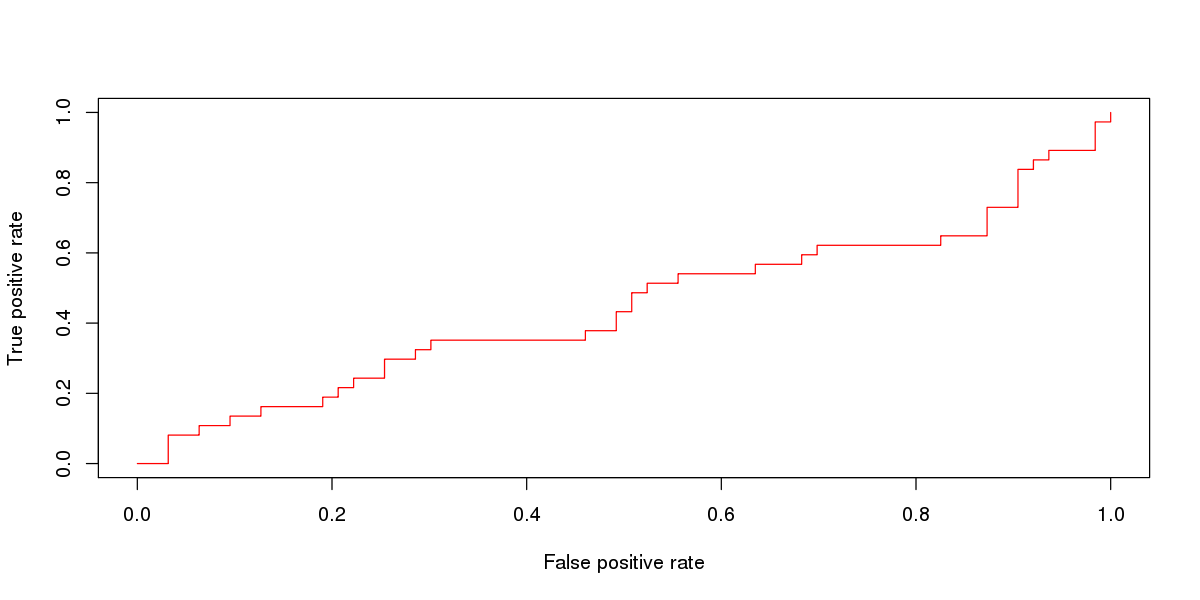

In [121]:
# basic ROC example
library(ROCR)
N <- 100
Y_prob <- rnorm(N)
Y_true <- as.integer(Y_vals + rnorm(N, mean = 0, sd = 2) > 0.5)
prediction_result <- prediction(Y_prob, Y_true)
perf <- performance(prediction_result, measure='tpr', x.measure='fpr')
plot(perf, col=redblue(10), height = 2, width = 2)

In [246]:
source('hi_est_logit.R')
source(caret)
run_h_estimate_basic <- function(t_var, c_vars, o_var, data){
    ## Run the Hirano-Imbens estimator for average dose
    ## response, using the specified treatment, control and output.
    
    # if no control vars, we assume that every variable except
    # treatment is control
    c_vars_0 <- c_vars
    if(length(c_vars) > 0){
        c_var_str <- paste(c_vars, collapse=',')
    }
    all_vars <- Filter(function(x) { return(x != 'word')}, colnames(data))
    quant_probs <- seq(0, 0.99, by=0.01)
    if(length(c_vars_0) == 0){
        c_vars <- Filter(function(x) { return(x != t_var & !(x %in% o_vars))}, all_vars)
        c_var_str <- paste(c_vars, collapse=',')
    }
    tmp_data <- as.data.frame(cbind(data[, t_var], data[, c_vars], data[, o_var]))
    colnames(tmp_data) <- c('T', c_vars, 'Y')
    tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
    grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
    # generate formulae
    treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
    outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
    # convert estimator command to text and parse
    hi_est_str <- paste(c("hi_est_logit(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
    hi_estimate <- eval(parse(text=hi_est_str))
    ## organize results
    hi_treatment_model <- hi_estimate[['t_mod']]
    hi_outcome_model <- hi_estimate[['out_mod']]
    hi_gps <- hi_estimate[['gps_fun']]
    hi_treatment_coeff <- hi_treatment_model[['coefficients']]
    hi_outcome_coeff <- hi_outcome_model[['coefficients']]
    treatment_colnames <- c('treatment_var', names(hi_treatment_coeff))
    outcome_colnames <- c('treatment_var', 'control_vars', names(hi_outcome_coeff))
    treatment_row <- c(t_var, as.vector(unlist(hi_treatment_coeff)))
    outcome_row <- c(t_var, c_var_str, as.vector(unlist(hi_outcome_coeff)))
    treatment_list <- setNames(as.list(treatment_row), treatment_colnames)
    outcome_list <- setNames(as.list(outcome_row), outcome_colnames)
    results <- list(treatment_coeff=treatment_list, outcome_coeff=outcome_list, 
                    treatment_model=hi_treatment_model,
                    outcome_model=hi_outcome_model,
                    gps=hi_gps)
    return(results)
}
balance_data <- function(data, class_var){
    class_counts <- table(data[, class_var])
    N_minority <- as.vector(sort(table(data[, class_var]), decreasing = FALSE)[1])[1]
    classes <- unique(data[, class_var])
    data_balanced <- data.frame()
    for(class_name in classes){
        relevant_data <- data[data[, class_var] == class_name]
        N_c <- dim(relevant_data)[1]
        relevant_data <- relevant_data[sample(N_c, N_minority, replace=TRUE), ]
        if(dim(data_balanced)[1] == 0){
            data_balanced <- relevant_data
        }
        else{
            data_balanced <- rbind(data_balanced, relevant_data)
        }
    }
    return(data_balanced)
}

train_test_model <- function(train_data, test_data, t_var, o_var, c_vars){
    ## train/test logistic regression model to predict success
    # (1) train
    model_results <- run_h_estimate_basic(t_var, c_vars, o_var, data)
    # (4) test
    outcome_coeff_names <- c('T', 'gps', '(Intercept)')
    gps_fun <- model_results[['gps']]
    outcome_coef <- as.double(unlist(model_results[['outcome_coeff']][outcome_coeff_names]))
    gps_fun_mean <- function(x){ return(mean(gps_fun(x)))}
    test_matrix <- cbind(test_data[, t_var], mapply(gps_fun_mean, test_data[, c_vars]), 1)
    colnames(test_matrix) <- outcome_coeff_names
    potential_outcomes <- t(outcome_coef %*% t(temp_matrix))
    potential_outcomes <- 1. / (1 + exp(-potential_outcomes))
    # (5) compute accuracy => AUC
    pred_results <- prediction(potential_outcomes, stats_combined_change[, 'success'])
    test_auc <- performance(pred_results, 'auc')
    test_auc <- as.numeric(test_auc@y.values)
    return(test_auc)
}
k_fold_test <- function(data, t_var, o_var, c_vars, train_pct=0.9){
    
}

In [183]:
# regenerate data because PARANOIA
time_step_range <- 1:12
all_stats <- list(f=f, DL=DL, DS=DS, DU=DU, DT=DT)
time_steps <- time_step_range[1]:time_step_range[2]
stat_names <- names(all_stats)
stats_combined <- combine_all_stats(all_stats, stat_names, time_steps)
# limit to change
stats_combined_change <- stats_combined[mapply(function(x) { return(x %in% change_words)}, stats_combined[, 'word']), ]
success_vals <- mapply(function(x) { return(as.integer(x %in% success_words))}, stats_combined_change[, 'word'])
success_vals <- data.frame(success_vals)
colnames(success_vals) <- 'success'
stats_combined_change <- cbind(stats_combined_change, success_vals)

In [ ]:

# (1) balance outcome classes
balanced_data <- balance_data(data, o_var)
# (2) train/test split
N <- dim(balanced_data)[1]
N_train <- as.integer(N*train_pct)
balanced_data <- balanced_data[sample(N, N, replace=FALSE), ]
train_data <- balanced_data[1:N_train, ]
test_data <- balanced_data[N_train:N, ]

### Testing AUC
Here's where we tested how to compute AUC using the estimated model. Include for historical purposes.

In [247]:
# test basic estimation
t_var <- 'DL'
o_var <- 'success'
c_vars <- c('f', 'DU', 'DS', 'DT')
## estimate
h_results <- run_h_estimate_basic(t_var, c_vars, o_var, stats_combined_change)

In [271]:
outcome_vars <- c('T', 'gps', '(Intercept)')
outcome_coef <- as.double(unlist(h_results[['outcome_coeff']][outcome_vars]))
print(outcome_coef)
test_data <- setNames(data.frame(c(1, 2), c(1, 2), c(1, 2)), outcome_vars)
test_outcome <- outcome_coef %*% t(test_data)
print(test_outcome)

[1]  0.5269544 -1.6751202  1.2825796
          [,1]      [,2]
[1,] 0.1344138 0.2688275


In [278]:
## try prediction!!
# following formula in hi_est_logit.R
gps_fun <- h_results[['gps']]
outcome_vars <- c('T', 'gps', '(Intercept)')
outcome_coef <- as.double(unlist(h_results[['outcome_coeff']][outcome_vars]))
gps_fun_mean <- function(x){ return(mean(gps_fun(x)))}
temp_matrix <- cbind(stats_combined_change[, t_var], mapply(gps_fun_mean, stats_combined_change[, c_vars]), 1)
colnames(temp_matrix) <- outcome_vars
print(head(temp_matrix))
potential_outcomes <- t(outcome_coef %*% t(temp_matrix))
potential_outcomes <- 1. / (1 + exp(-potential_outcomes))
print(head(potential_outcomes))

Warning message in cbind(stats_combined_change[, t_var], mapply(gps_fun_mean, stats_combined_change[, :
“number of rows of result is not a multiple of vector length (arg 2)”

              T       gps (Intercept)
[1,] -4.3017389 0.2230899           1
[2,] -3.0019660 0.3477107           1
[3,] -3.0460264 0.2737436           1
[4,] -1.6365756 0.3073859           1
[5,] -2.8504106 0.2230899           1
[6,] -0.4479556 0.3477107           1
          [,1]
[1,] 0.2045748
[2,] 0.2928097
[3,] 0.3140848
[4,] 0.4763353
[5,] 0.3559103
[6,] 0.6139793


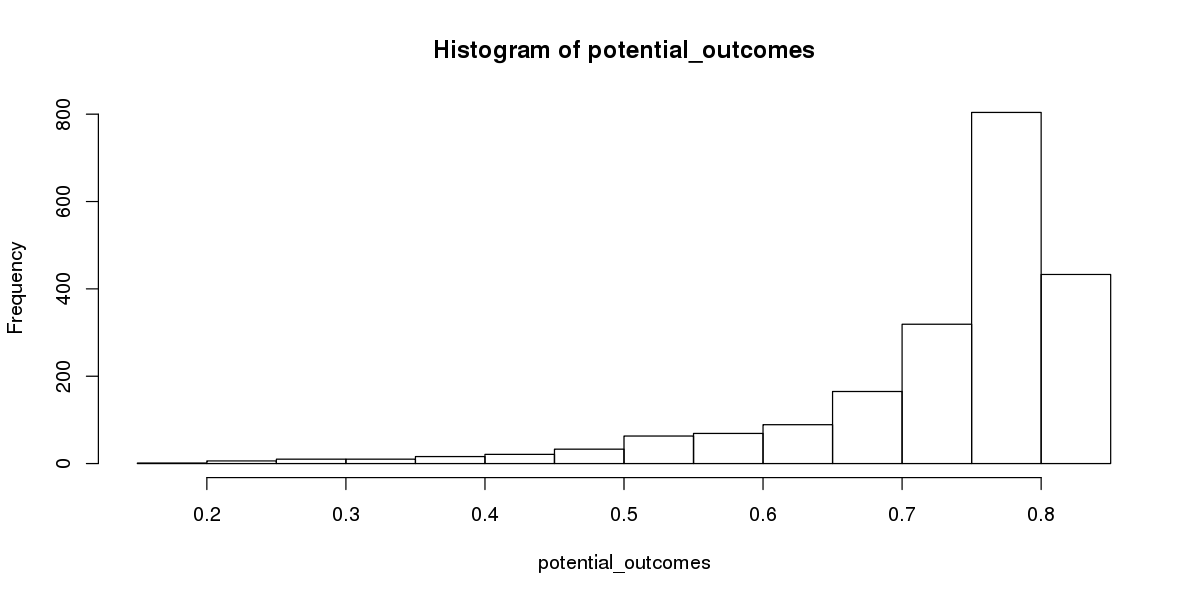

In [279]:
hist(potential_outcomes)

This distribution is weirdly skewed to the right, but maybe the AUC isn't too bad?

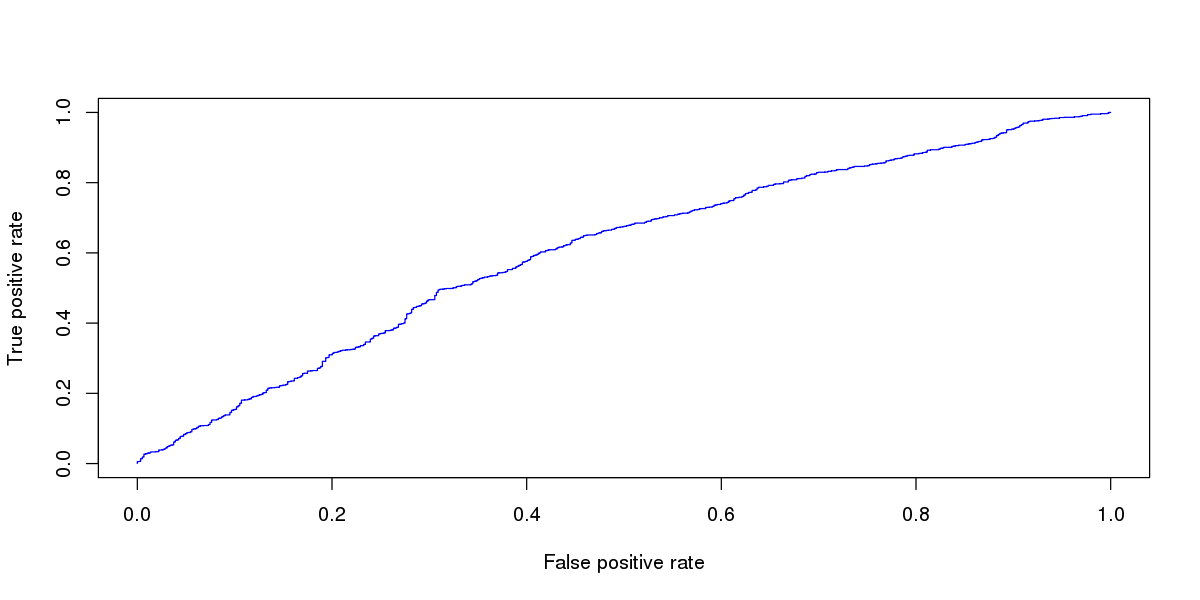

In [281]:
library(ROCR)
pred_results <- prediction(potential_outcomes, stats_combined_change[, 'success'])
perf <- performance(pred_results, measure = 'tpr', x.measure = 'fpr')
plot(perf, col=bluered(10))

In [285]:
test_auc <- performance(pred_results, 'auc')
test_auc <- as.numeric(test_auc@y.values)
print(test_auc)

[1] 0.607907


OK! So let's use AUC to measure accuracy.

## Density plot for bootstrap
Let's make sure that the bootstrap test is actually measuring confidence, because those intervals are weirdly small.

Instead of trying to be smart and computing CIs, we will just overlay the time series and see what the density looks like.

In [1]:
source('prediction_helpers.R')

Loading required package: survival
The optmatch package has an academic license. Enter relaxinfo() for more information.
Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:survival’:

    cluster

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [2]:
all_stats <- load_all_stats()
stat_names <- names(all_stats)
time_steps <- 1:12
stats_combined <- combine_all_stats(all_stats, stat_names, time_steps, rescale=TRUE)
data_dir <- '../../data/frequency'
word_lists <- load_word_lists(data_dir)
success_words <- word_lists[['success']]
fail_words <- word_lists[['failure']]
change_words <- c(success_words, fail_words)
is_change <- mapply(function(x){return(x %in% change_words)}, stats_combined[, 'word'])
stats_combined_change <- stats_combined[is_change, ]
# add success column to combined data
stats_combined_change[, 'success'] <- mapply(function(x){return(as.integer(x %in% success_words))}, stats_combined_change[, 'word'])

In [8]:
source('prediction_helpers.R')
set.seed(123)
t_vars <- c('DL', 'DU', 'DS', 'DT')
o_var <- 'success'
c_vars <- c()
class_var <- 'success'
bootstrap_iters <- 100
timestep_range <- paste(time_steps[1], tail(time_steps,1), sep='_')
quant_size <- 0.1
quant_probs <- seq(0, 1., by=quant_size)
all_control_success_prob_results <- run_bootstrap_balanced_class(t_vars, c_vars, o_var, 
                                                                 class_var, timestep_range, stats_combined_change, 
                                                                 bootstrap_iters, quant_probs=quant_probs)

[1] "processed 10 bootstrap iters"
[1] "processed 20 bootstrap iters"
[1] "processed 30 bootstrap iters"
[1] "processed 40 bootstrap iters"
[1] "processed 50 bootstrap iters"
[1] "processed 60 bootstrap iters"
[1] "processed 70 bootstrap iters"
[1] "processed 80 bootstrap iters"
[1] "processed 90 bootstrap iters"
[1] "processed 100 bootstrap iters"


In [9]:
bootstrap_vals <- all_control_success_prob_results[['vals']]
print(head(bootstrap_vals))
print(dim(bootstrap_vals))

  timesteps treatment_name control_vars          0       0.1       0.2
1      1_12             DL   f,DS,DU,DT 0.22938964 0.4347628 0.4510658
2      1_12             DU   f,DL,DS,DT 0.27245458 0.4037056 0.4452602
3      1_12             DS   f,DL,DU,DT 0.42636486 0.4592765 0.4731335
4      1_12             DT   f,DL,DS,DU 0.38503353 0.4349839 0.4542552
5      1_12             DL   f,DS,DU,DT 0.07545509 0.3669946 0.4098582
6      1_12             DU   f,DL,DS,DT 0.28752622 0.4041835 0.4450741
        0.3       0.4       0.5       0.6       0.7       0.8       0.9
1 0.4692974 0.4999393 0.5217708 0.5401684 0.5590208 0.5762551 0.5941335
2 0.4713905 0.4892784 0.5005751 0.5081569 0.5136178 0.5158981 0.5172371
3 0.4876000 0.4962947 0.5088670 0.5222783 0.5356090 0.5509892 0.5720620
4 0.4699071 0.4806952 0.4875698 0.4889937 0.4870908 0.4836030 0.4789146
5 0.4498215 0.4966416 0.5324999 0.5610632 0.5912248 0.6155514 0.6380398
6 0.4740747 0.4899866 0.5023493 0.5149485 0.5204973 0.5238964 0.5273214

In [17]:
print(as.character(quant_probs))

 [1] "0"   "0.1" "0.2" "0.3" "0.4" "0.5" "0.6" "0.7" "0.8" "0.9" "1"  


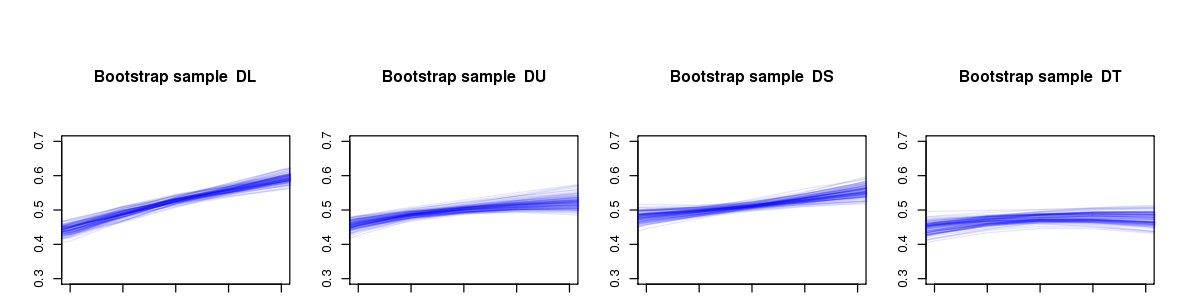

In [44]:
# try density plot
library(scales)
x <- quant_probs
quant_probs_str <- as.character(quant_probs)
options(repr.plot.width = 10, repr.plot.height = 2.5)
par(mfrow=c(1, 4), oma=c(1, 2, 1, 1), mai = c(0, 0.25, 1, 0.25))
for(t_var in t_vars){
    # dummy plot
    plot(c(0.5), c(0.5), main=paste('Bootstrap sample ', t_var), xlab='Treatment level', ylab='P(success)', col = alpha('black', 0.))
    for(i in 1:bootstrap_iters){
        y <- as.vector(unlist(bootstrap_vals[bootstrap_vals[, 'treatment_name']==t_var & bootstrap_vals[, 'iter'] == i, ][, quant_probs_str]))
        lines(x, y, col = alpha('blue', 0.1), type='l')
    }
}

There we go! So it's not exact matching but pretty close. I bet the confidence intervals won't be as impressive as before if we use standard deviation instead of error.

In [ ]:
# same thing but with confidence intervals
options(repr.plot.width = 10, repr.plot.height = 2.5)
par(mfrow=c(1, 4), oma=c(1, 2, 1, 1), mai = c(0, 0.25, 1, 0.25))
for(t_var in t_vars){
    # dummy plot
    plot(c(0.5), c(0.5), main=paste('Bootstrap sample ', t_var), xlab='Treatment level', ylab='P(success)', col = alpha('black', 0.))
    # upper/lower CIs
    t_vals <- bootstrap_vals[bootstrap_vals[, 'treatment_name'] == t_var, ]
    ci_upper <-
    for(i in 1:bootstrap_iters){
        y <- as.vector(unlist(bootstrap_vals[bootstrap_vals[, 'treatment_name']==t_var & bootstrap_vals[, 'iter'] == i, ][, quant_probs_str]))
        lines(x, y, col = alpha('blue', 0.1), type='l')
    }
}